In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import pandas as pd

# Set path to the root Dataset directory
dataset_root = "./Dataset"  # change this to your dataset path
combined_data = []

# Loop through each subject folder
for subject in os.listdir(dataset_root):
    subject_path = os.path.join(dataset_root, subject)
    if os.path.isdir(subject_path):
        for file in os.listdir(subject_path):
            if file.endswith(".csv"):
                file_path = os.path.join(subject_path, file)
                try:
                    df = pd.read_csv(file_path)
                    df["Subject"] = subject
                    df["Trial"] = os.path.splitext(file)[0]  # e.g., test1
                    df["Gender"] = 'male'
                    combined_data.append(df)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

# Combine all into a single DataFrame
full_dataset = pd.concat(combined_data, ignore_index=True)
print("Shape of full dataset:", full_dataset.shape)
print("Sample data:\n", full_dataset)
full_dataset = full_dataset.dropna()
print(full_dataset.isna().any().any())  # Returns True if any NaNs are present
print(full_dataset.isna().sum())

Shape of full dataset: (552519, 39)
Sample data:
         RS_AccelX  RS_AccelY  RS_AccelZ  RS_GyroX  RS_GyroY  RS_GyroZ  \
0           -0.10      -0.17       0.89     -4.91     13.92      9.69   
1           -0.10      -0.16       0.89     -4.85     13.38      9.89   
2           -0.11      -0.15       0.88     -4.60     12.69      9.67   
3           -0.11      -0.16       0.89     -4.50     12.02      9.50   
4           -0.10      -0.16       0.89     -3.85     11.57      9.48   
...           ...        ...        ...       ...       ...       ...   
552514      -0.00       0.03       0.91     10.19     -5.37      1.58   
552515      -0.02       0.03       0.92      9.40     -5.79      1.76   
552516      -0.01       0.04       0.93      9.42     -5.98      1.82   
552517      -0.01       0.05       0.93      8.86     -5.71      1.95   
552518        NaN        NaN        NaN       NaN       NaN       NaN   

        RA_AccelX  RA_AccelY  RA_AccelZ  RA_GyroX  ...  LA_GyroZ  LS_Acce

In [3]:
# 2. Reshape Data for ANOVA and Comparisons
# 1. Identify only sensor measurement columns
sensor_columns = [col for col in full_dataset.columns if '_' in col and col.split('_')[0] in ['RS', 'RA', 'RT', 'LT', 'LA', 'LS']]
print("Sensor columns:", sensor_columns)
# 2. Melt only those columns
reshaped_data = full_dataset.melt(
    id_vars=['Subject', 'Trial'],
    value_vars=sensor_columns,
    var_name='Measurement',
    value_name='Value'
)
reshaped_data['Joint'] = reshaped_data['Measurement'].str.extract(r'_(\w+)$')
reshaped_data["Side"] = reshaped_data["Measurement"].str[0].map({'L': 'Left', 'R': 'Right'})

Sensor columns: ['RS_AccelX', 'RS_AccelY', 'RS_AccelZ', 'RS_GyroX', 'RS_GyroY', 'RS_GyroZ', 'RA_AccelX', 'RA_AccelY', 'RA_AccelZ', 'RA_GyroX', 'RA_GyroY', 'RA_GyroZ', 'RT_AccelX', 'RT_AccelY', 'RT_AccelZ', 'RT_GyroX', 'RT_GyroY', 'RT_GyroZ', 'LT_AccelX', 'LT_AccelY', 'LT_AccelZ', 'LT_GyroX', 'LT_GyroY', 'LT_GyroZ', 'LA_AccelX', 'LA_AccelY', 'LA_AccelZ', 'LA_GyroX', 'LA_GyroY', 'LA_GyroZ', 'LS_AccelX', 'LS_AccelY', 'LS_AccelZ', 'LS_GyroX', 'LS_GyroY', 'LS_GyroZ']


In [4]:
print(reshaped_data.columns)

Index(['Subject', 'Trial', 'Measurement', 'Value', 'Joint', 'Side'], dtype='object')


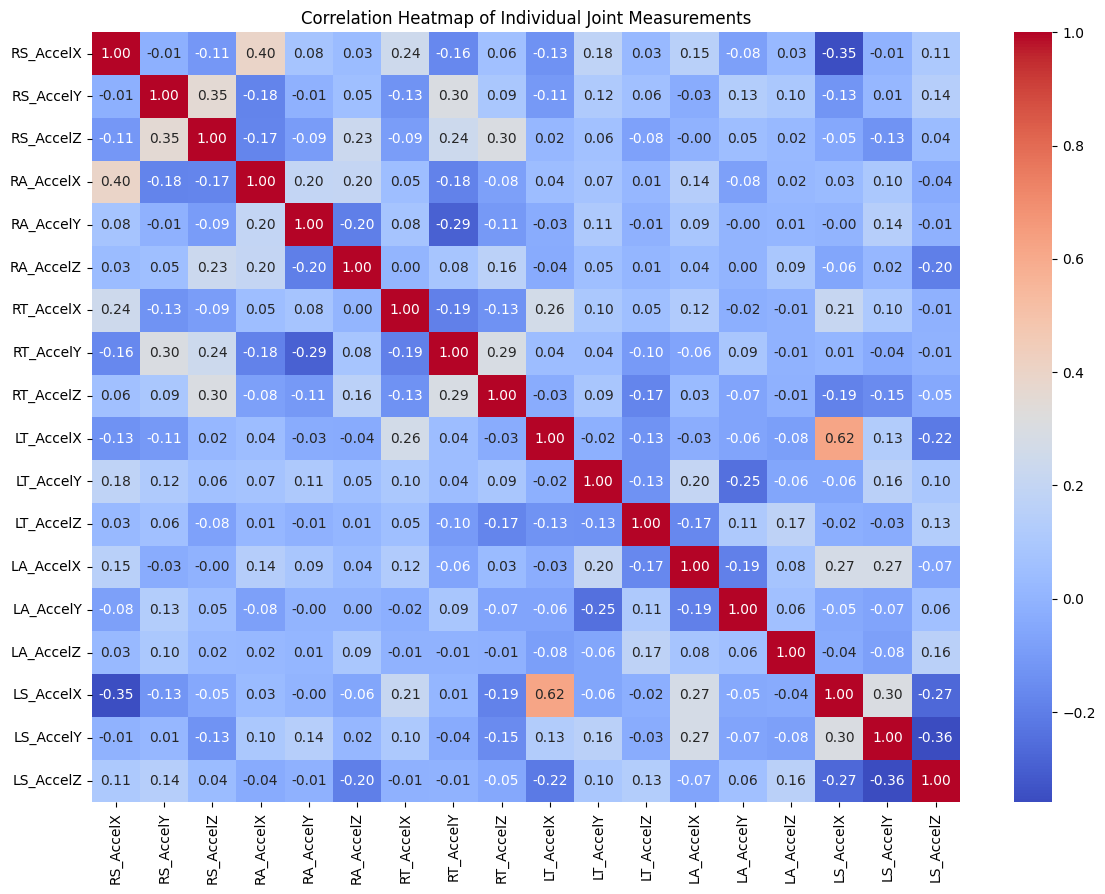

In [5]:
# 3. Correlation Matrix
columns_of_interest = [col for col in full_dataset.columns if 'AccelX' in col or 'AccelY' in col or 'AccelZ' in col]
correlation_matrix = full_dataset[columns_of_interest].corr()
# 4. Plot Correlations Between Individual Joint Pairs
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title('Correlation Heatmap of Individual Joint Measurements')
plt.show()
# print("Correlation Matrix:")
# print(correlation_matrix)

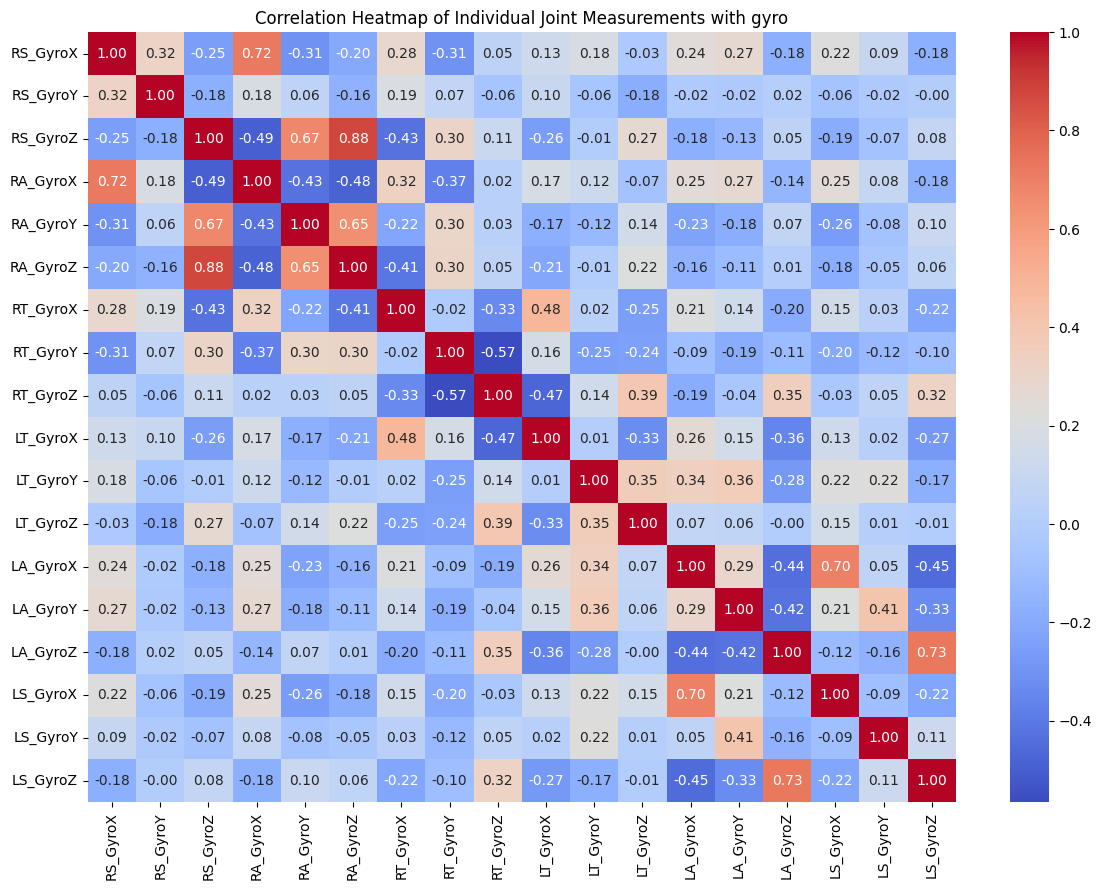

In [6]:
columns_of_interest_gyro = [col for col in full_dataset.columns if 'GyroX' in col or 'GyroY' in col or 'GyroZ' in col]
correlation_matrix_gyro = full_dataset[columns_of_interest_gyro].corr()
# 4. Plot Correlations Between Individual Joint Pairs
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_gyro, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title('Correlation Heatmap of Individual Joint Measurements with gyro')
plt.show()
# print("Correlation Matrix Gyro:")
# print(correlation_matrix_gyro)

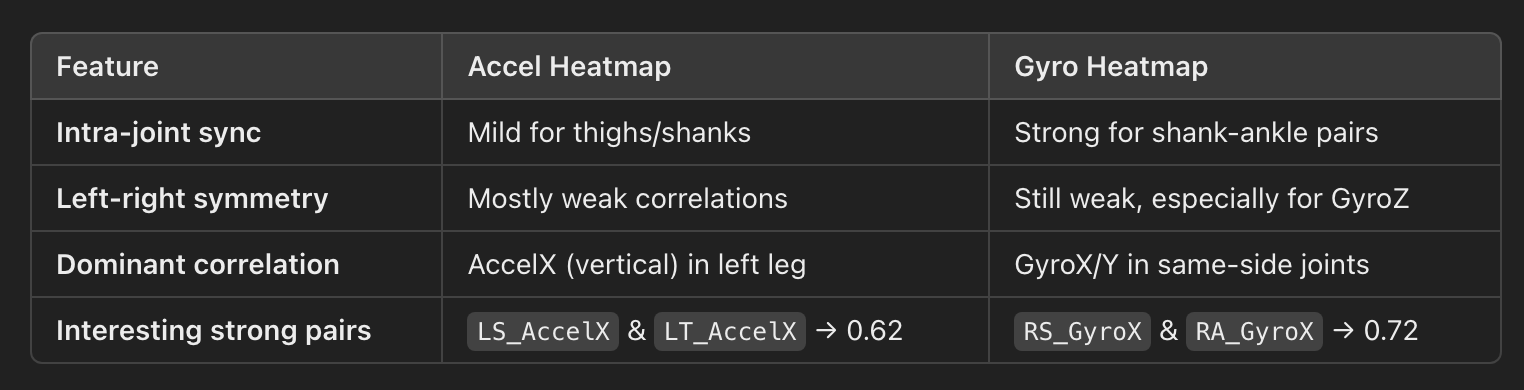

In [7]:
from scipy import stats
import numpy as np

def perform_anova(group_col, data):
    # Ensure 'Value' is numeric
    data = data.copy()
    data["Value"] = pd.to_numeric(data["Value"], errors="coerce")
    
    # Drop rows with NaNs in 'Value' (due to coercion)
    data = data.dropna(subset=["Value"])

    groups = [group["Value"].values for _, group in data.groupby(group_col)]
    
    # Check if there's enough variation
    if len(groups) < 2 or any(len(g) < 2 for g in groups):
        return {"ANOVA Statistic": np.nan, "p-value": np.nan, "Note": "Not enough data for ANOVA"}

    result = stats.f_oneway(*groups)
    return {"ANOVA Statistic": result.statistic, "p-value": result.pvalue}


In [8]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# model = ols('Value ~ C(Joint) + C(Subject) + C(Joint):C(Subject)', data=reshaped_data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# print(anova_table)

In [9]:
# 6. Two-Way ANOVA Comparisons
anova_joints = perform_anova("Joint", reshaped_data)
print("\nANOVA: Between and Within Joints")
print(anova_joints)

anova_subjects = perform_anova("Subject", reshaped_data)
print("\nANOVA: Between and Within Subjects")
print(anova_subjects)

anova_left_right = perform_anova("Side", reshaped_data)
print("\nANOVA: Left vs Right Joints")
print(anova_left_right)

anova_trial = perform_anova("Trial", reshaped_data)
print("\nANOVA: Between and Within Trials")
print(anova_trial)

# anova_gender = perform_anova("Gender", reshaped_data)
# print("\nANOVA: Male vs Female Joints")
# print(anova_gender)


ANOVA: Between and Within Joints
{'ANOVA Statistic': 3154.5392087906166, 'p-value': 0.0}

ANOVA: Between and Within Subjects
{'ANOVA Statistic': 468.82632368718896, 'p-value': 0.0}

ANOVA: Left vs Right Joints
{'ANOVA Statistic': 523.7079241280438, 'p-value': 6.627399206255145e-116}

ANOVA: Between and Within Trials
{'ANOVA Statistic': 26.533745767497887, 'p-value': 3.474461463142427e-235}


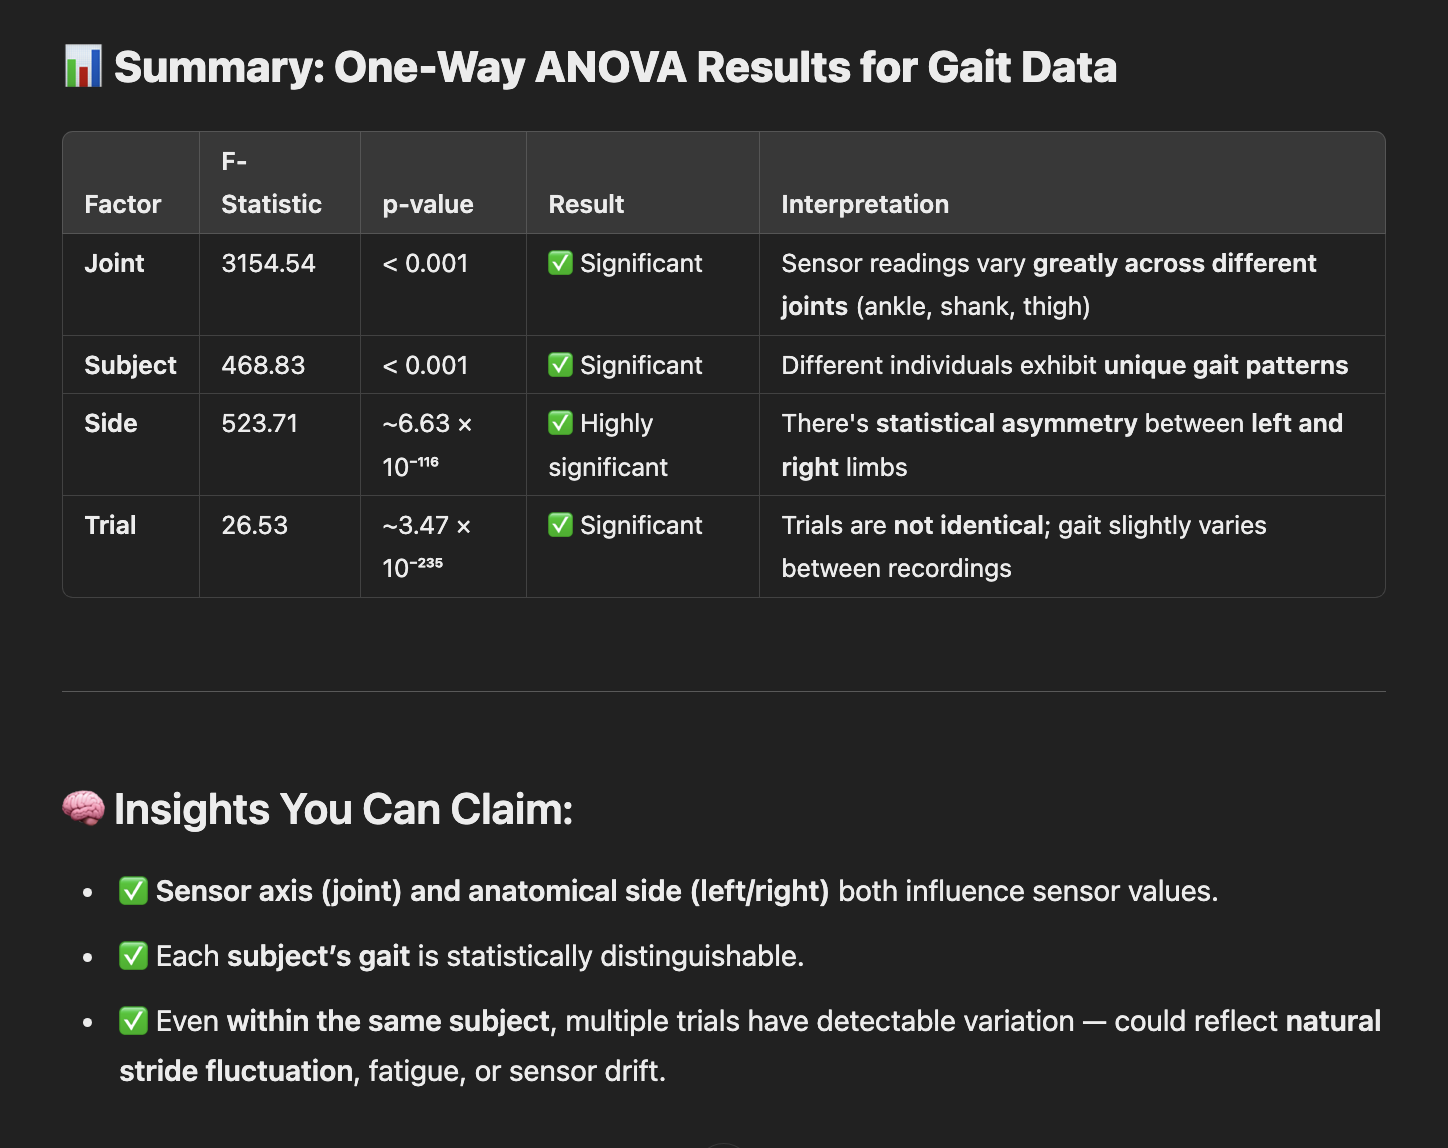

In [10]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# sampled_data = reshaped_data.sample(n=50000, random_state=42)  # or even 100000 if your system allows

# # Prepare the model
# model = ols('Value ~ C(Subject) + C(Joint) + C(Subject):C(Joint)', data=sampled_data).fit()

# # Perform two-way ANOVA
# anova_table = sm.stats.anova_lm(model, typ=2)
# print("\nTwo-Way ANOVA (Subject × Joint):")
# print(anova_table)


In [11]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [12]:
# Drop NaNs to avoid errors
tukey_data = reshaped_data.dropna(subset=['Joint', 'Value'])

# Run Tukey's HSD
tukey_result = pairwise_tukeyhsd(
    endog=tukey_data['Value'], 
    groups=tukey_data['Joint'], 
    alpha=0.05
)

# Print results
print(tukey_result.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
AccelX AccelY   0.0599 0.3295 -0.0245  0.1442  False
AccelX AccelZ   0.9855    0.0  0.9011  1.0698   True
AccelX  GyroX  -0.6156    0.0 -0.6999 -0.5312   True
AccelX  GyroY   2.7386    0.0  2.6542  2.8229   True
AccelX  GyroZ   0.3517    0.0  0.2674  0.4361   True
AccelY AccelZ   0.9256    0.0  0.8412    1.01   True
AccelY  GyroX  -0.6755    0.0 -0.7598 -0.5911   True
AccelY  GyroY   2.6787    0.0  2.5943  2.7631   True
AccelY  GyroZ   0.2919    0.0  0.2075  0.3762   True
AccelZ  GyroX  -1.6011    0.0 -1.6854 -1.5167   True
AccelZ  GyroY   1.7531    0.0  1.6687  1.8375   True
AccelZ  GyroZ  -0.6337    0.0 -0.7181 -0.5494   True
 GyroX  GyroY   3.3542    0.0  3.2698  3.4385   True
 GyroX  GyroZ   0.9673    0.0   0.883  1.0517   True
 GyroY  GyroZ  -2.3868    0.0 -2.4712 -2.3025   True
----------------------------------------------

# TUKEY HSD

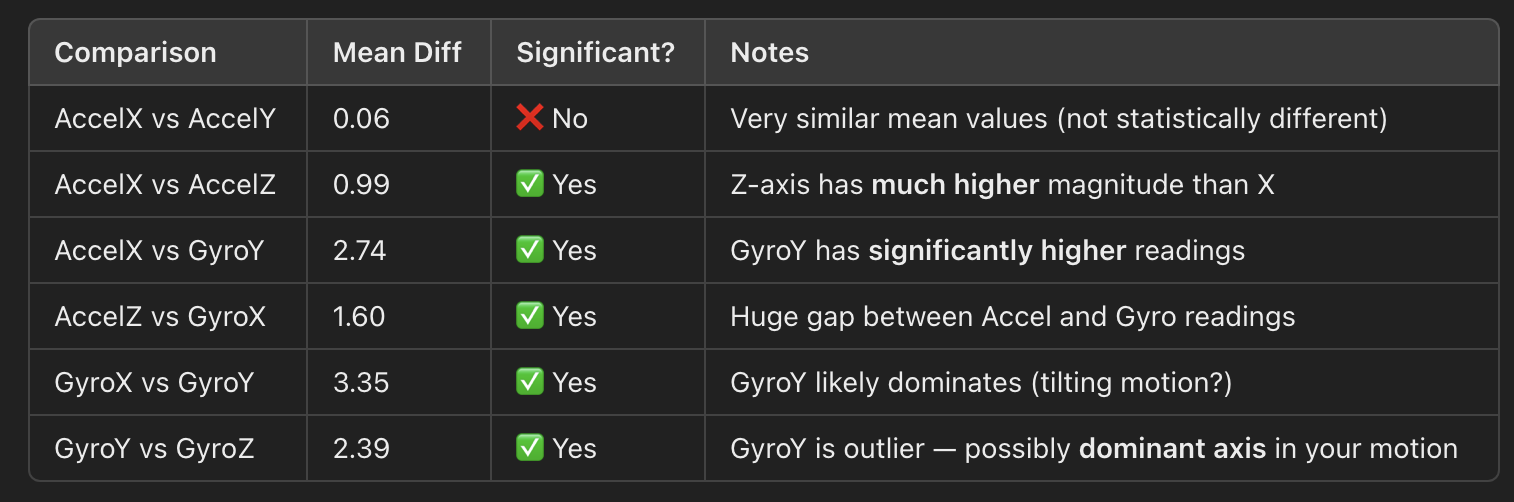

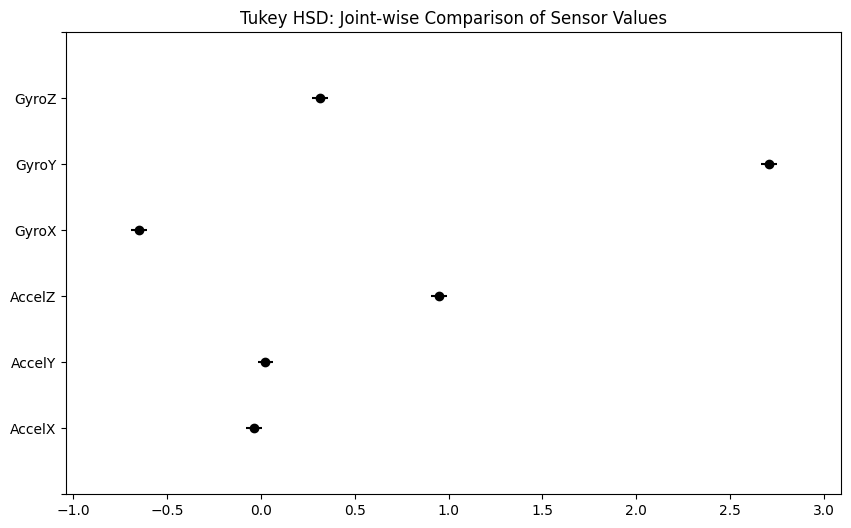

In [13]:
import matplotlib.pyplot as plt
tukey_result.plot_simultaneous(figsize=(10, 6))
plt.title("Tukey HSD: Joint-wise Comparison of Sensor Values")
plt.show()

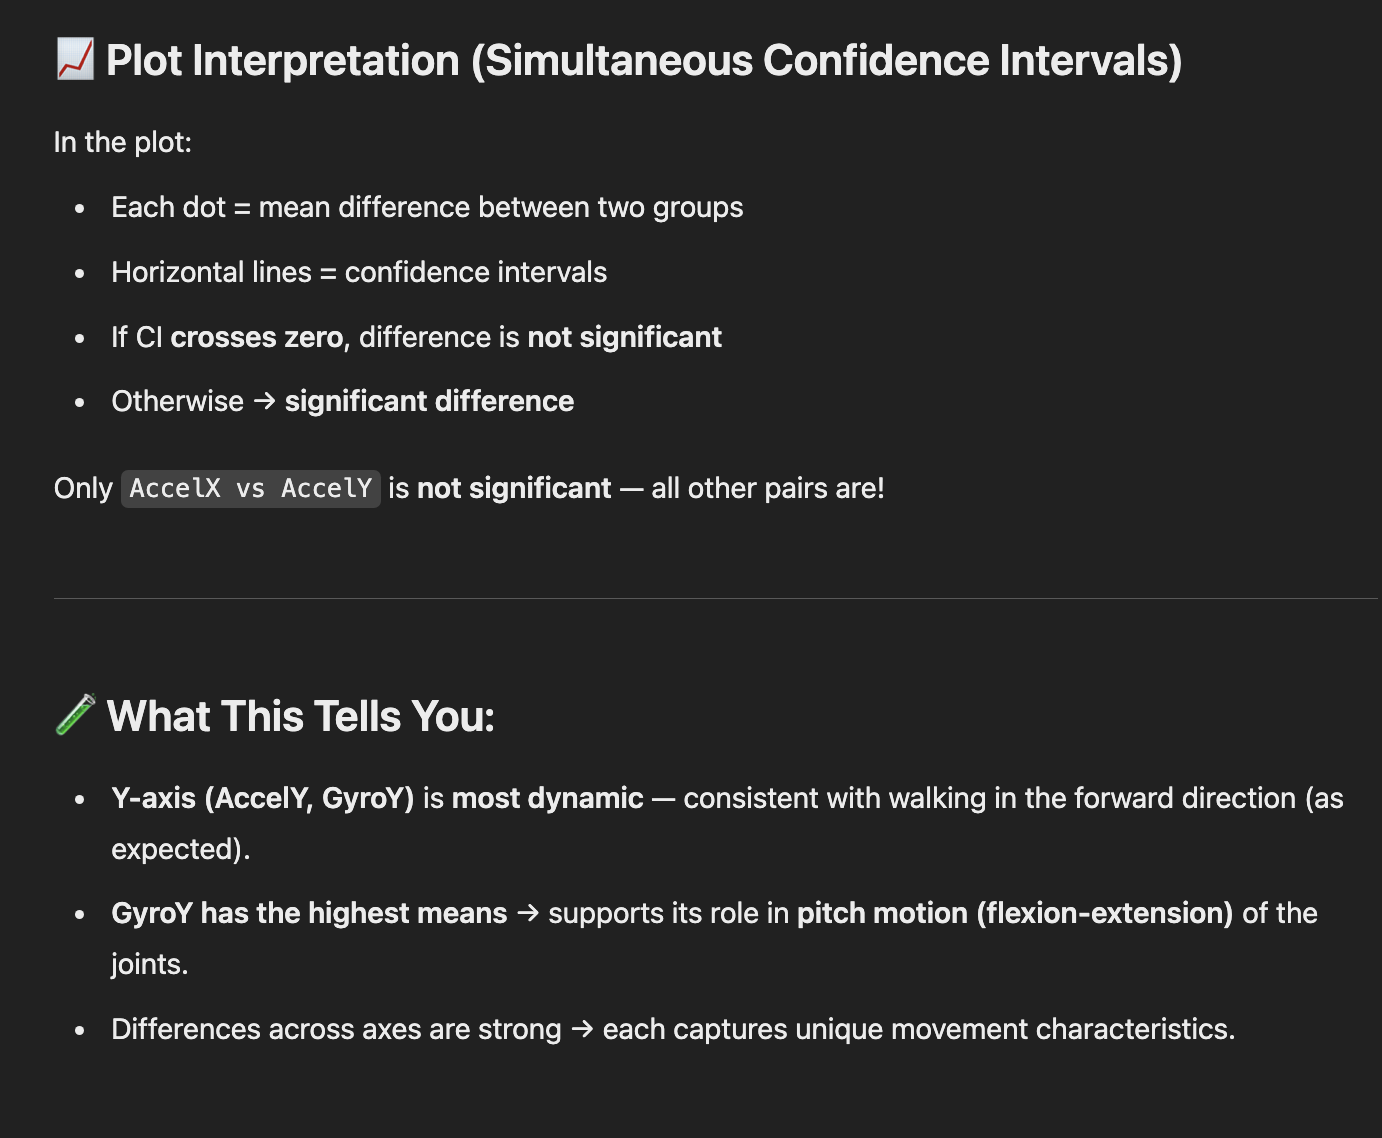

In [14]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Drop NaNs for safety
tukey_subject_data = reshaped_data.dropna(subset=['Subject', 'Value'])

# Run Tukey HSD on Subject
tukey_subject = pairwise_tukeyhsd(
    endog=tukey_subject_data['Value'],
    groups=tukey_subject_data['Subject'],
    alpha=0.05
)

# Print summary
print(tukey_subject.summary())


     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
abhijith-bc abhijith-cb   0.5472    0.0  0.4773  0.6171   True
abhijith-bc    anshuman   0.0405 0.9323 -0.0806  0.1616  False
abhijith-bc    patient1  -0.2428    0.0 -0.3674 -0.1182   True
abhijith-bc    patient2   1.3965    0.0  1.2689  1.5241   True
abhijith-bc    patient3   1.4454    0.0  1.3278   1.563   True
abhijith-cb    anshuman  -0.5067    0.0 -0.6146 -0.3987   True
abhijith-cb    patient1    -0.79    0.0 -0.9019 -0.6782   True
abhijith-cb    patient2   0.8493    0.0  0.7341  0.9645   True
abhijith-cb    patient3   0.8982    0.0  0.7942  1.0022   True
   anshuman    patient1  -0.2834    0.0 -0.4327  -0.134   True
   anshuman    patient2    1.356    0.0  1.2042  1.5078   True
   anshuman    patient3   1.4049    0.0  1.2613  1.5484   True
   patient1    patient2   1.6393    0.0  1.4847  1.7939

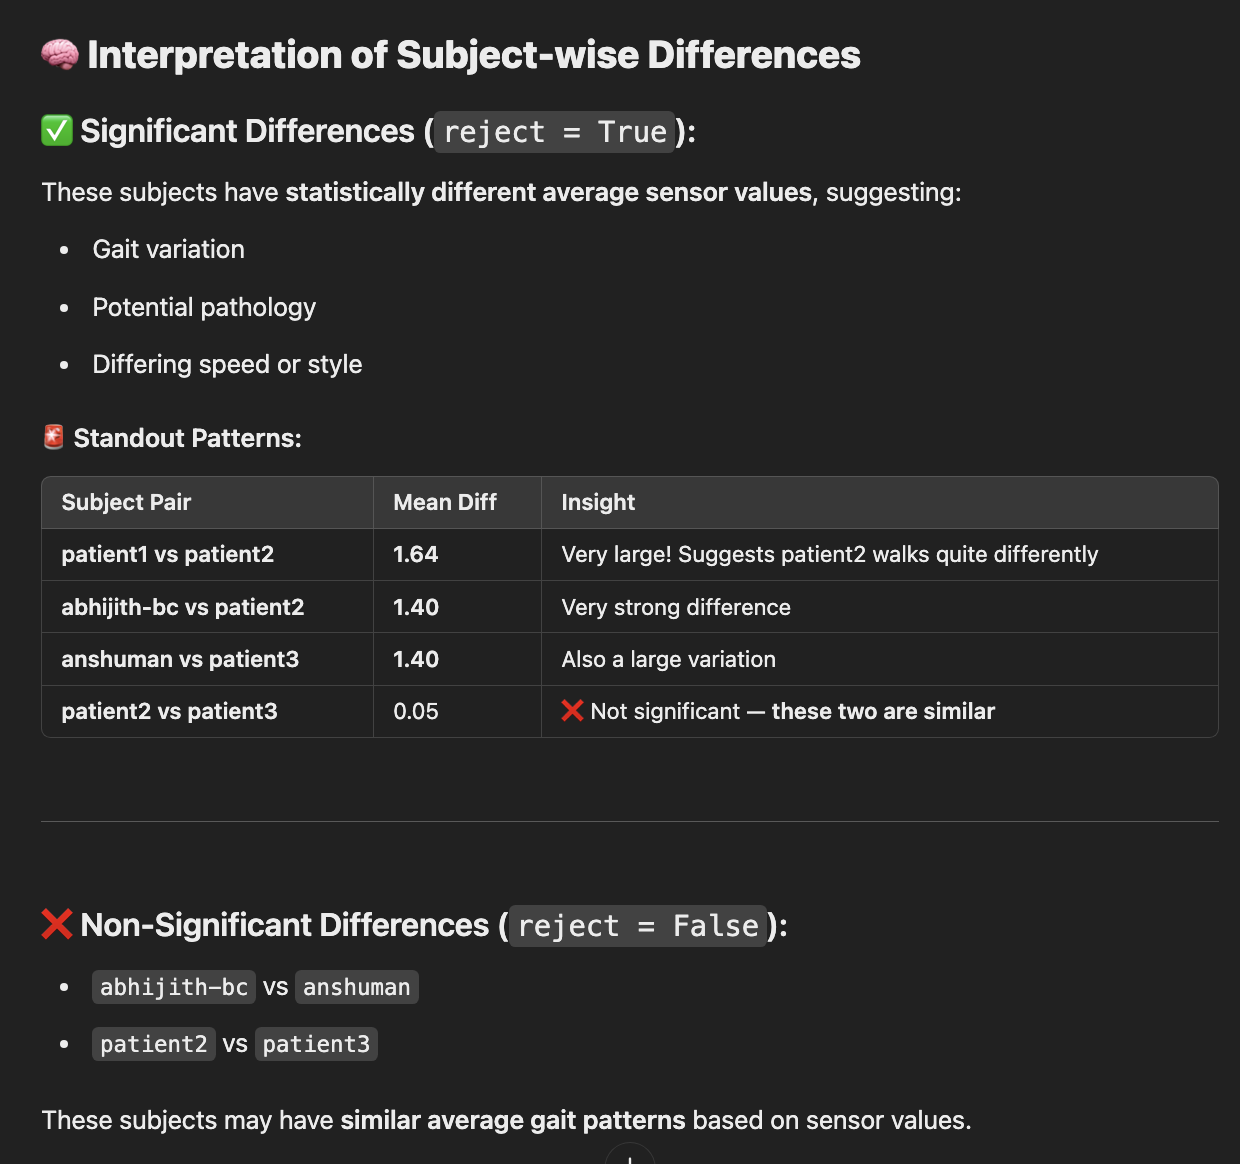

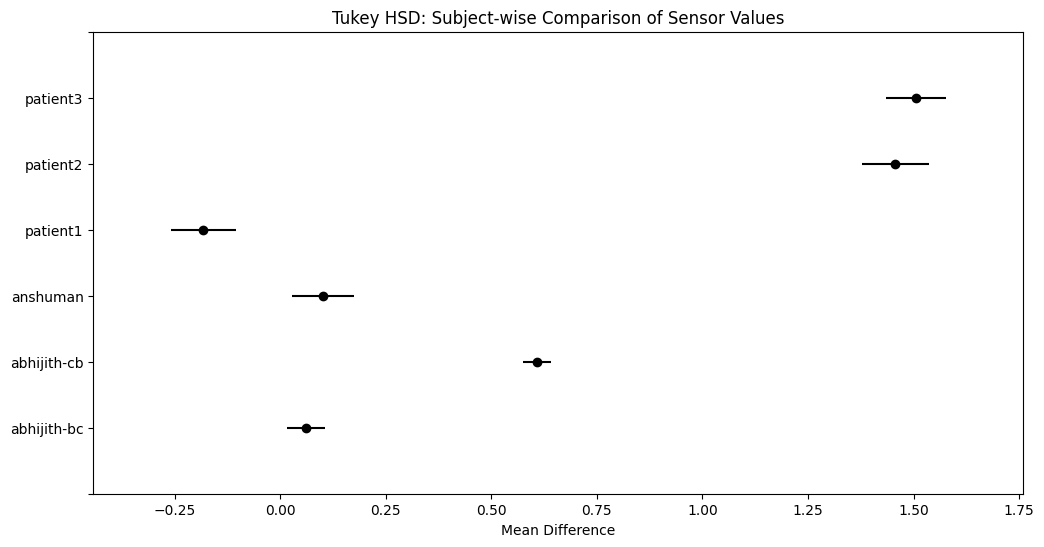

In [15]:
tukey_subject.plot_simultaneous(figsize=(12, 6))
plt.title("Tukey HSD: Subject-wise Comparison of Sensor Values")
plt.xlabel("Mean Difference")
plt.show()

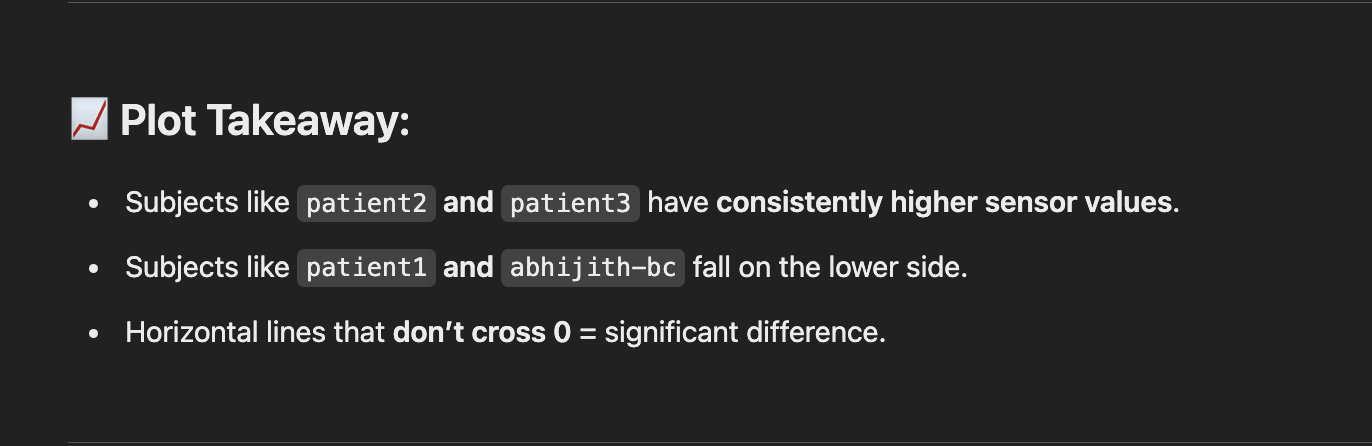

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
  Left  Right   0.3913   0.0 0.3578 0.4248   True
-------------------------------------------------


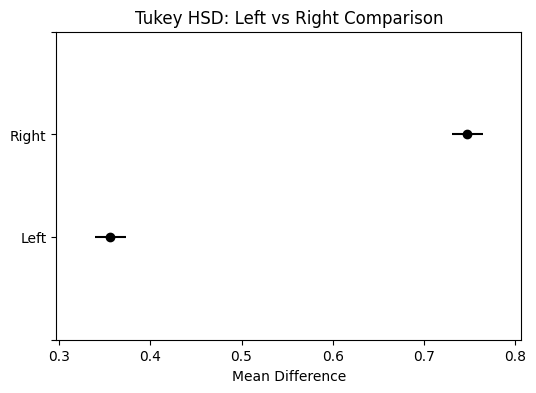

In [16]:
# Drop NaNs for safety
tukey_side_data = reshaped_data.dropna(subset=['Side', 'Value'])

# Run Tukey HSD on Side
tukey_side = pairwise_tukeyhsd(
    endog=tukey_side_data['Value'],
    groups=tukey_side_data['Side'],
    alpha=0.05
)

# Print summary
print(tukey_side.summary())

# Plot
tukey_side.plot_simultaneous(figsize=(6, 4))
plt.title("Tukey HSD: Left vs Right Comparison")
plt.xlabel("Mean Difference")
plt.show()

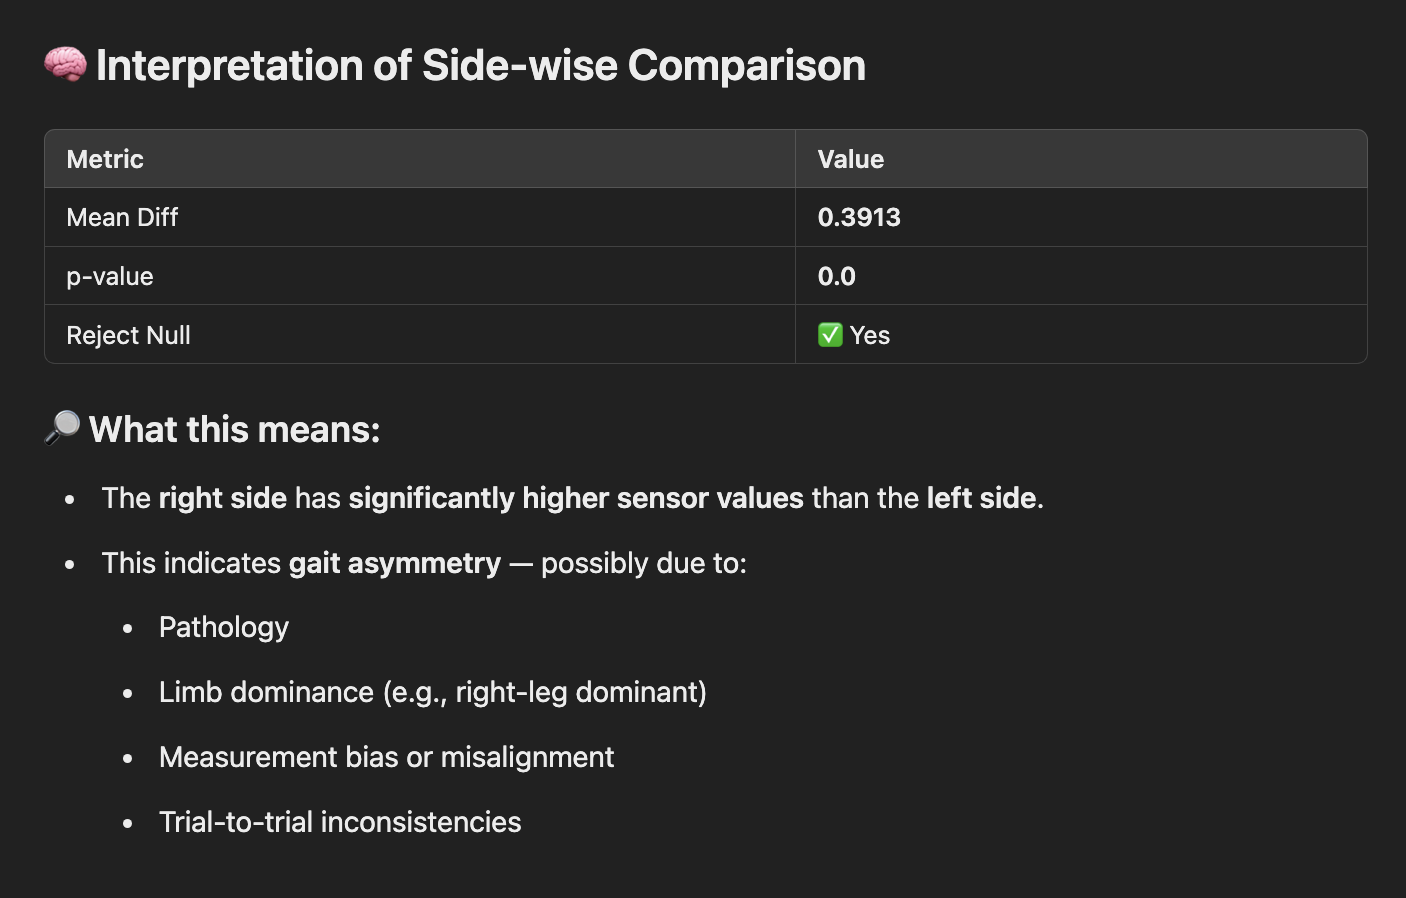

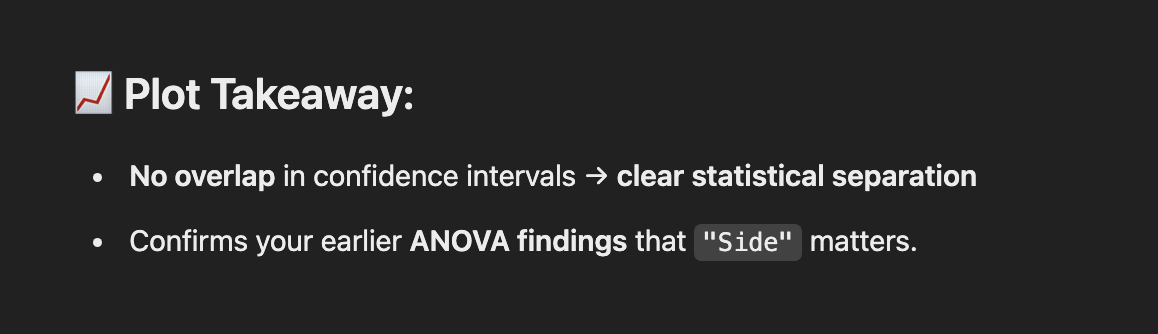

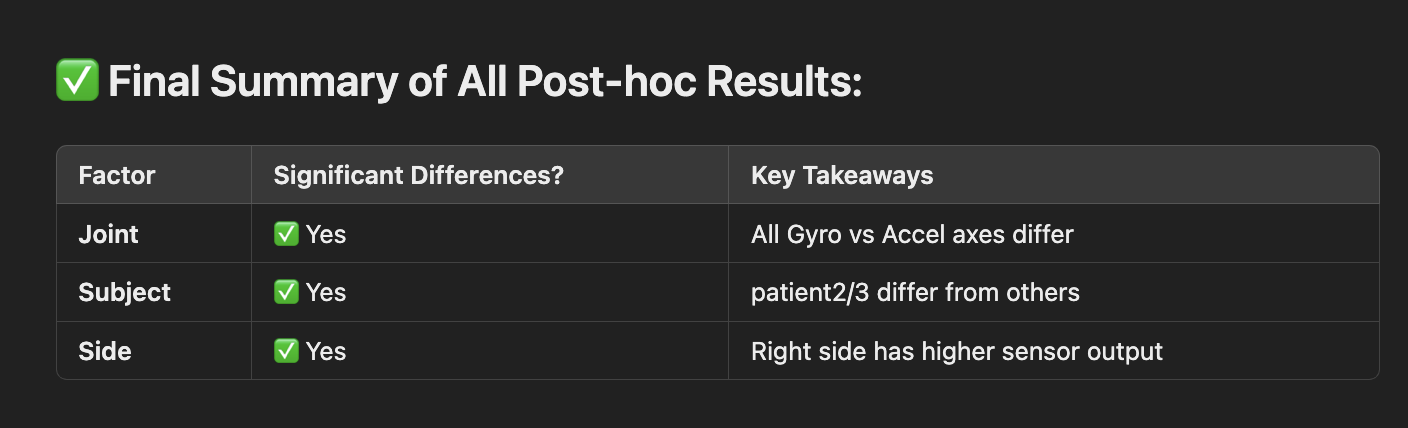


=== Subject: patient1 ===
LT_AccelY vs RT_AccelY → Correlation r = -0.05
LS_AccelY vs RS_AccelY → Correlation r = -0.02
LA_AccelY vs RA_AccelY → Correlation r = 0.01


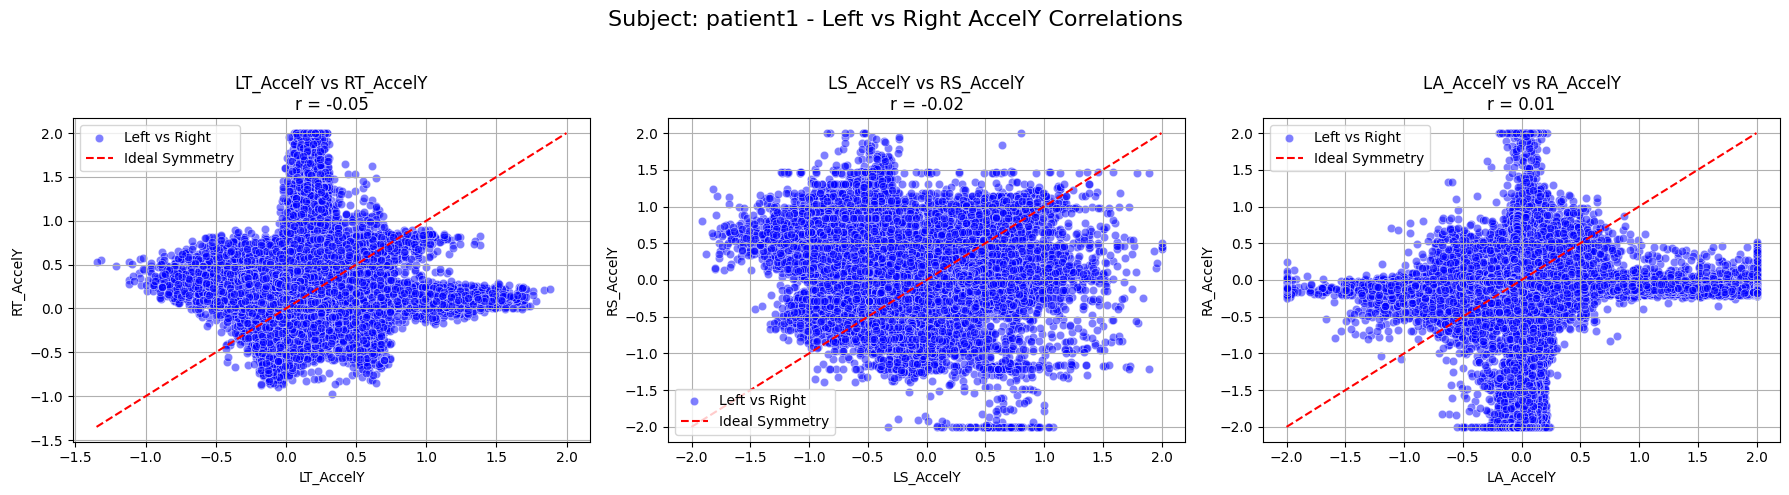


=== Subject: abhijith-cb ===
LT_AccelY vs RT_AccelY → Correlation r = 0.10
LS_AccelY vs RS_AccelY → Correlation r = 0.05
LA_AccelY vs RA_AccelY → Correlation r = -0.02


/var/folders/2d/fcgrngd95_b823fdj1fwwj840000gn/T/ipykernel_20207/505804301.py:71: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
/Users/manoj/Documents/gait-research/profiling_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


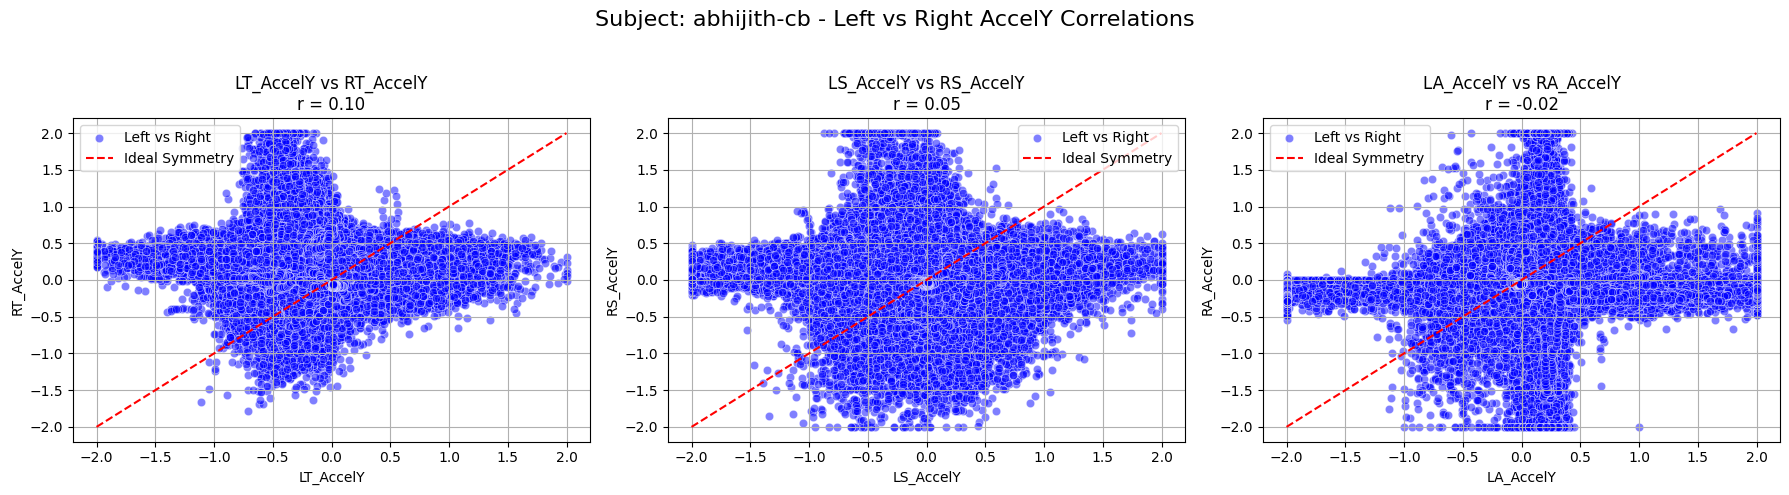


=== Subject: patient2 ===
LT_AccelY vs RT_AccelY → Correlation r = -0.11
LS_AccelY vs RS_AccelY → Correlation r = -0.09
LA_AccelY vs RA_AccelY → Correlation r = 0.06


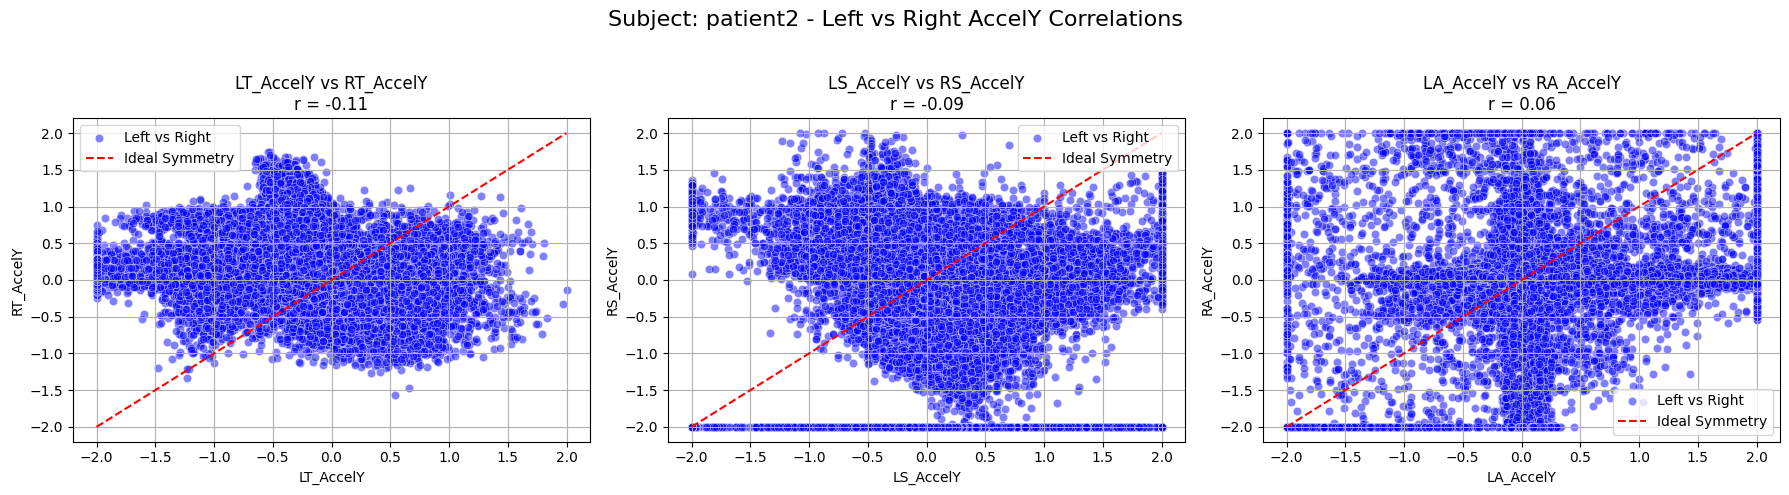


=== Subject: patient3 ===
LT_AccelY vs RT_AccelY → Correlation r = 0.01
LS_AccelY vs RS_AccelY → Correlation r = 0.10
LA_AccelY vs RA_AccelY → Correlation r = -0.23


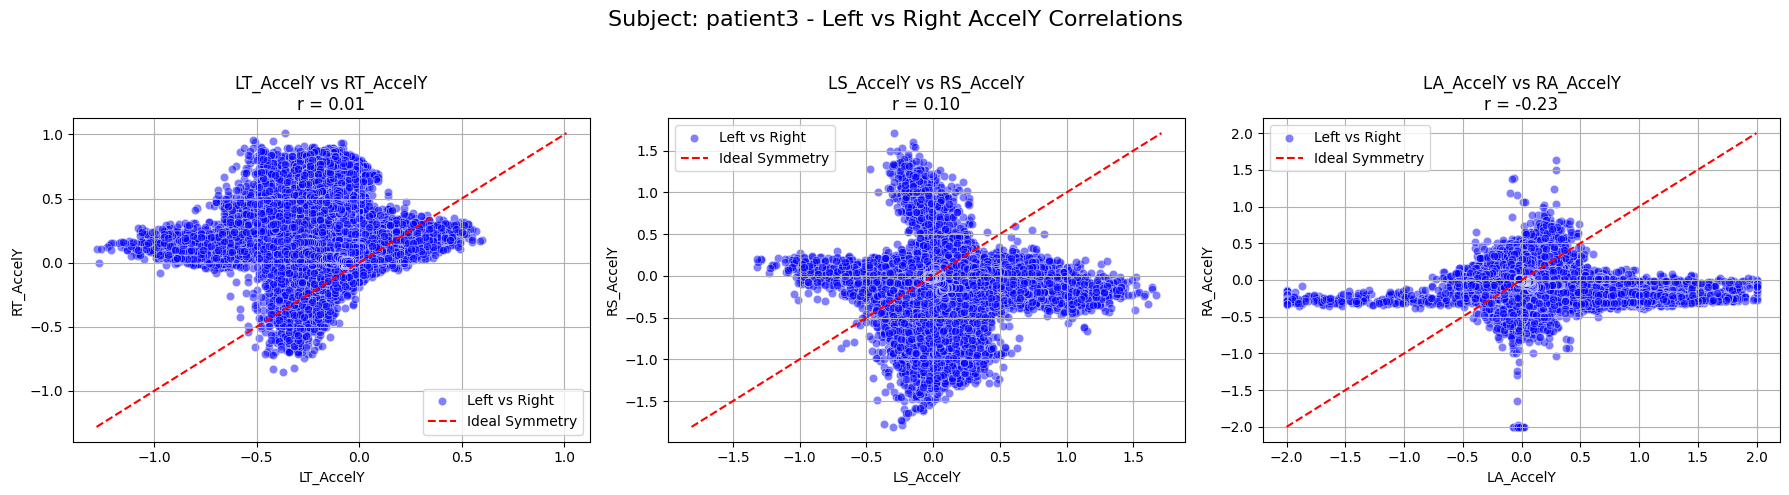


=== Subject: anshuman ===
LT_AccelY vs RT_AccelY → Correlation r = -0.13
LS_AccelY vs RS_AccelY → Correlation r = -0.04
LA_AccelY vs RA_AccelY → Correlation r = -0.00


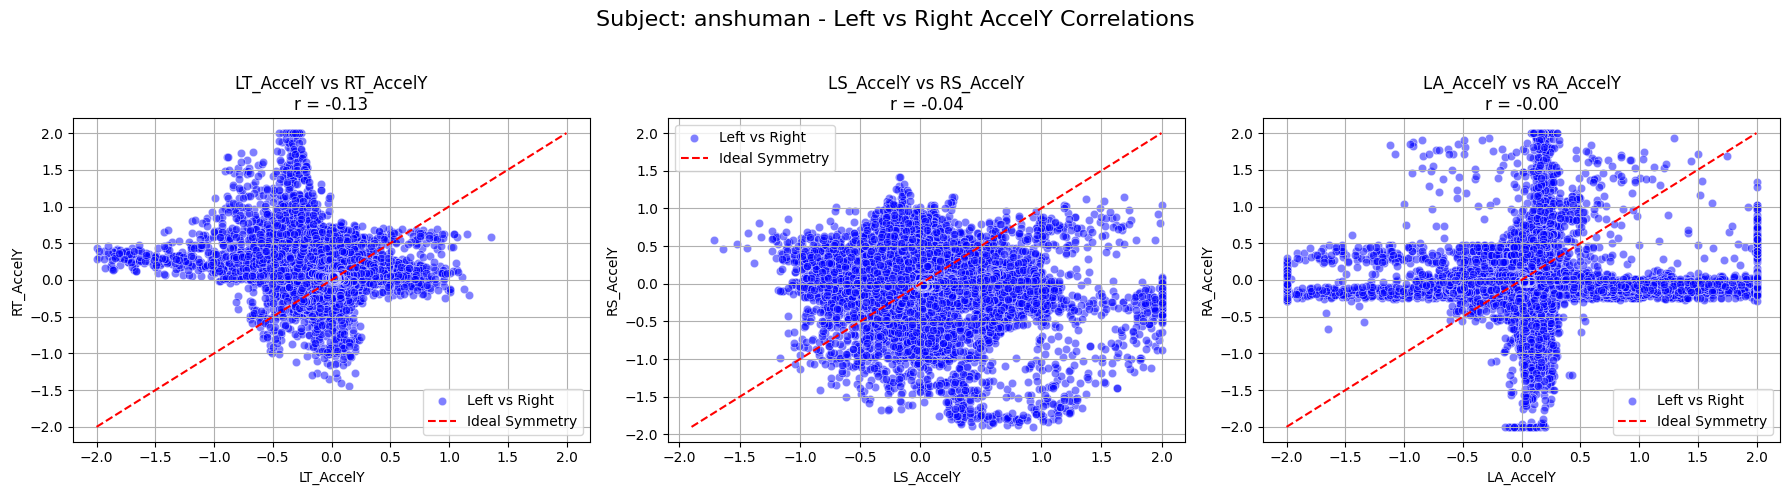


=== Subject: abhijith-bc ===
LT_AccelY vs RT_AccelY → Correlation r = 0.07
LS_AccelY vs RS_AccelY → Correlation r = 0.27
LA_AccelY vs RA_AccelY → Correlation r = 0.09


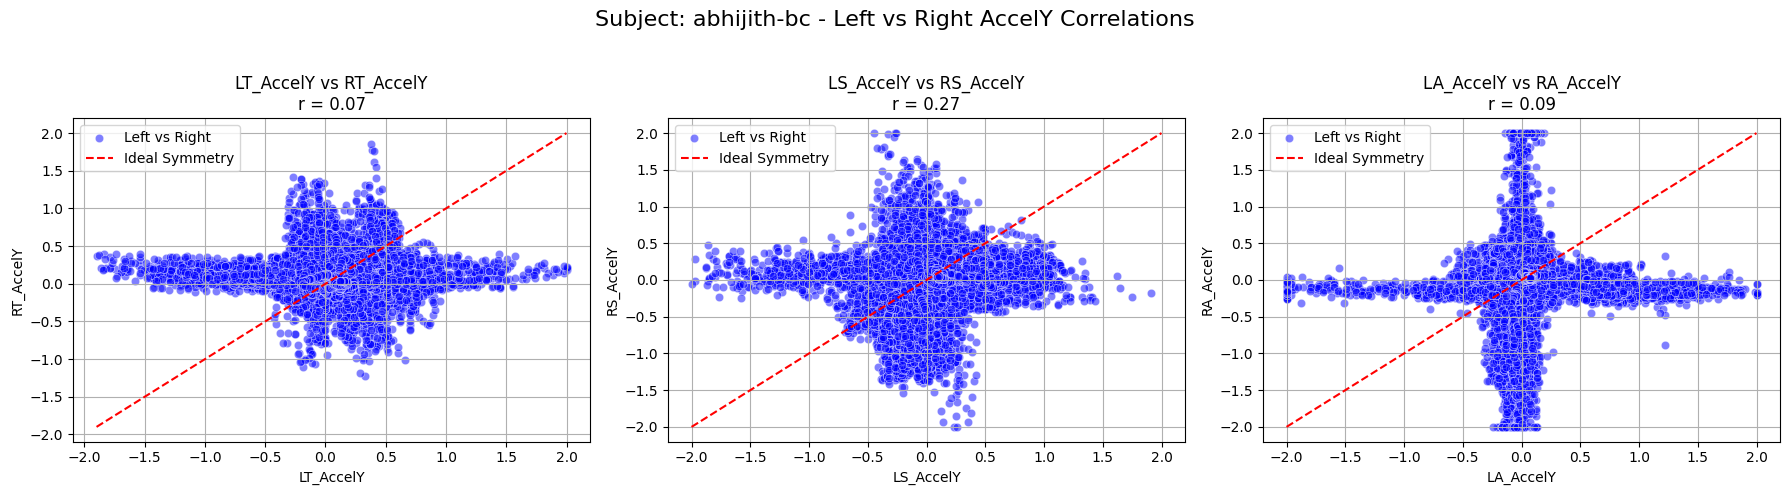

       Subject   LT_Corr   LT_Asym   LS_Corr   LS_Asym   LA_Corr   LA_Asym  \
0     patient1 -0.048718  0.951282 -0.015934  0.984066  0.014650  0.985350   
1  abhijith-cb  0.100755  0.899245  0.050461  0.949539 -0.021719  0.978281   
2     patient2 -0.107613  0.892387 -0.090922  0.909078  0.058038  0.941962   
3     patient3  0.009100  0.990900  0.103286  0.896714 -0.227718  0.772282   
4     anshuman -0.126835  0.873165 -0.044706  0.955294 -0.002104  0.997896   

   Avg_Asym  
0  0.973566  
1  0.942355  
2  0.914475  
3  0.886632  
4  0.942119  


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Define joint pairs
joint_pairs = [
    ('LT_AccelY', 'RT_AccelY'),
    ('LS_AccelY', 'RS_AccelY'),
    ('LA_AccelY', 'RA_AccelY')
]

asymmetry_results = []

# Loop over each subject
for subject in full_dataset['Subject'].unique():
    subject_data = full_dataset[full_dataset['Subject'] == subject]
    result = {"Subject": subject}
    asym_scores = []
    print(f"\n=== Subject: {subject} ===")

    # Create subplot figure with 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Subject: {subject} - Left vs Right AccelY Correlations', fontsize=16)

    for i, (joint1, joint2) in enumerate(joint_pairs):
        ax = axes[i]

        # Drop NaNs just for this pair
        valid_data = subject_data[[joint1, joint2]].dropna()

        if not valid_data.empty:
            # Pearson correlation
            r, _ = pearsonr(valid_data[joint1], valid_data[joint2])
            asym = 1 - abs(r)
            print(f"{joint1} vs {joint2} → Correlation r = {r:.2f}")

            # Scatter plot
            sns.scatterplot(
                x=valid_data[joint1],
                y=valid_data[joint2],
                color='blue',
                alpha=0.5,
                label='Left vs Right',
                ax=ax
            )

            # Symmetry line
            min_val = min(valid_data.min())
            max_val = max(valid_data.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Symmetry')

            # Plot formatting
            ax.set_title(f'{joint1} vs {joint2}\nr = {r:.2f}')
            ax.set_xlabel(joint1)
            ax.set_ylabel(joint2)
            ax.grid(True)
            ax.legend()
        else:
            print(f"{joint1} vs {joint2} → No valid data to compute correlation.")
            ax.set_visible(False)
            r, asym = np.nan, np.nan
        joint_tag = joint1[:2]  # 'LT', 'LS', 'LA'
        result[f'{joint_tag}_Corr'] = r
        result[f'{joint_tag}_Asym'] = asym
        asym_scores.append(asym)
    
    result["Avg_Asym"] = np.nanmean(asym_scores)
    asymmetry_results.append(result)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()

# Convert to DataFrame
asymmetry_df = pd.DataFrame(asymmetry_results)

# Optionally save
# asymmetry_df.to_csv("asymmetry_scores.csv", index=False)

# Display
print(asymmetry_df.head())

In [18]:
from ydata_profiling import ProfileReport

profile = ProfileReport(asymmetry_df, title="Gait Asymmetry Report")
profile.to_file("asymmetry_report.html")

/Users/manoj/Documents/gait-research/profiling_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 453.24it/s]


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

sns.set(style="whitegrid")

def plot_asymmetry_summary(asymmetry_df, save=False, output_dir="asymmetry_plots"):
    # Create output directory if saving plots
    if save:
        os.makedirs(output_dir, exist_ok=True)

    # --- 1. Bar Plot: Average Asymmetry per Subject ---
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(
        data=asymmetry_df.sort_values("Avg_Asym", ascending=False),
        x="Avg_Asym", y="Subject", palette="coolwarm", hue="Subject", dodge=False
    )
    # barplot.legend_.remove()  # Remove duplicate legend
    plt.title("Average Gait Asymmetry per Subject")
    plt.xlabel("Avg Asymmetry Score")
    plt.ylabel("Subject")
    plt.tight_layout()
    if save:
        plt.savefig(f"{output_dir}/barplot_avg_asymmetry.png")
    plt.show()

    # --- 2. Heatmap: Correlation Matrix of Features ---
    plt.figure(figsize=(7, 6))
    corr = asymmetry_df.drop(columns=["Subject"]).corr()
    sns.heatmap(corr, annot=True, cmap="vlag", fmt=".2f", square=True)
    plt.title("Correlation Between Asymmetry Features")
    plt.tight_layout()
    if save:
        plt.savefig(f"{output_dir}/heatmap_correlation.png")
    plt.show()

    # --- 3. Histograms with KDE: Distribution of Each Metric ---
    numeric_cols = asymmetry_df.drop(columns=["Subject"]).columns
    ncols = 3
    nrows = (len(numeric_cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(asymmetry_df[col], bins=20, kde=True, ax=axes[i], color="steelblue")
        axes[i].set_title(f"Distribution: {col}")
        axes[i].set_xlabel("")
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.suptitle("Distribution of Asymmetry Metrics", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save:
        plt.savefig(f"{output_dir}/distribution_histograms.png")
    plt.show()

    # --- 4. Plotly Interactive: LT_Corr vs Avg_Asym ---
    fig = px.scatter(
        asymmetry_df,
        x="LT_Corr", y="Avg_Asym",
        color="Subject",
        size="Avg_Asym",
        title="LT_Corr vs Avg Asymmetry",
        labels={"LT_Corr": "LT Correlation", "Avg_Asym": "Average Asymmetry"}
    )
    if save:
        fig.write_html(f"{output_dir}/ltcorr_vs_asym.html")
    fig.show()


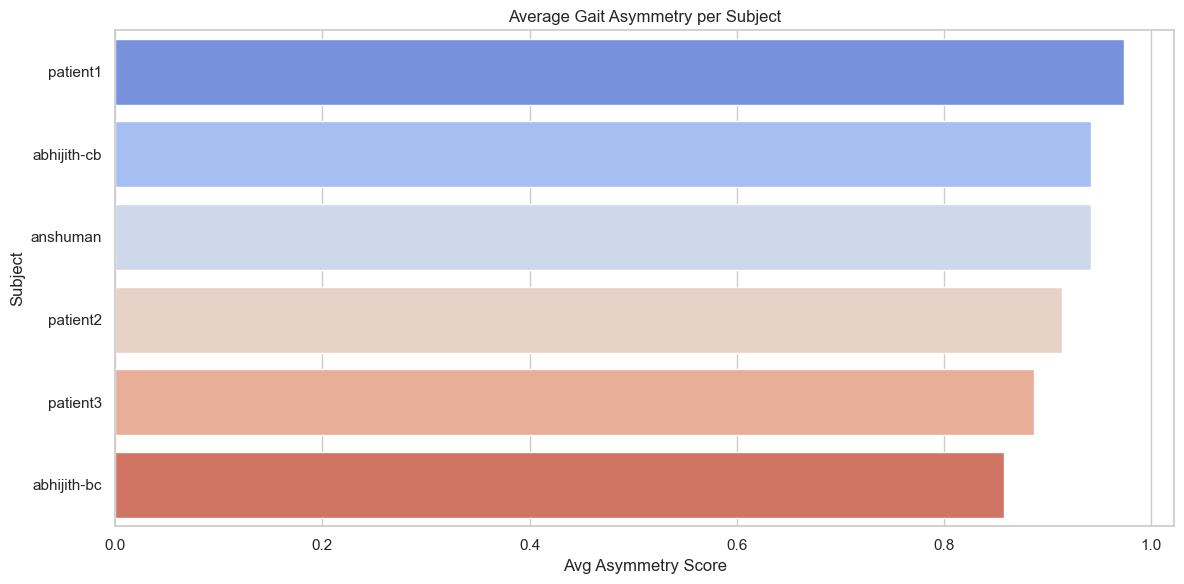

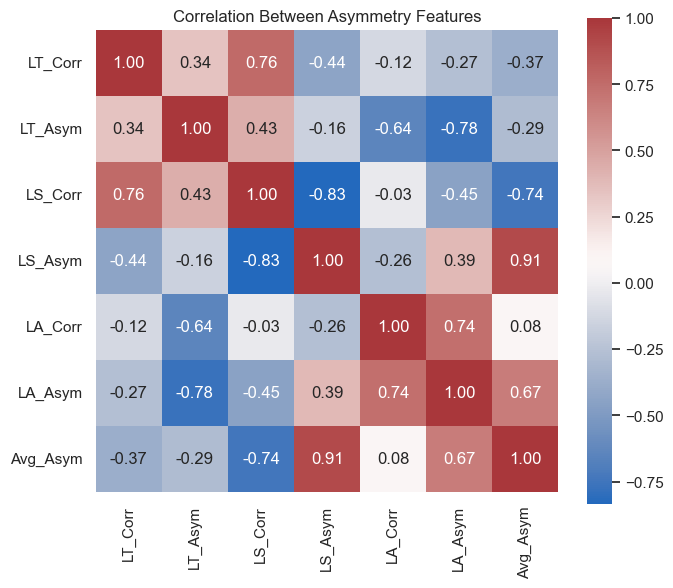

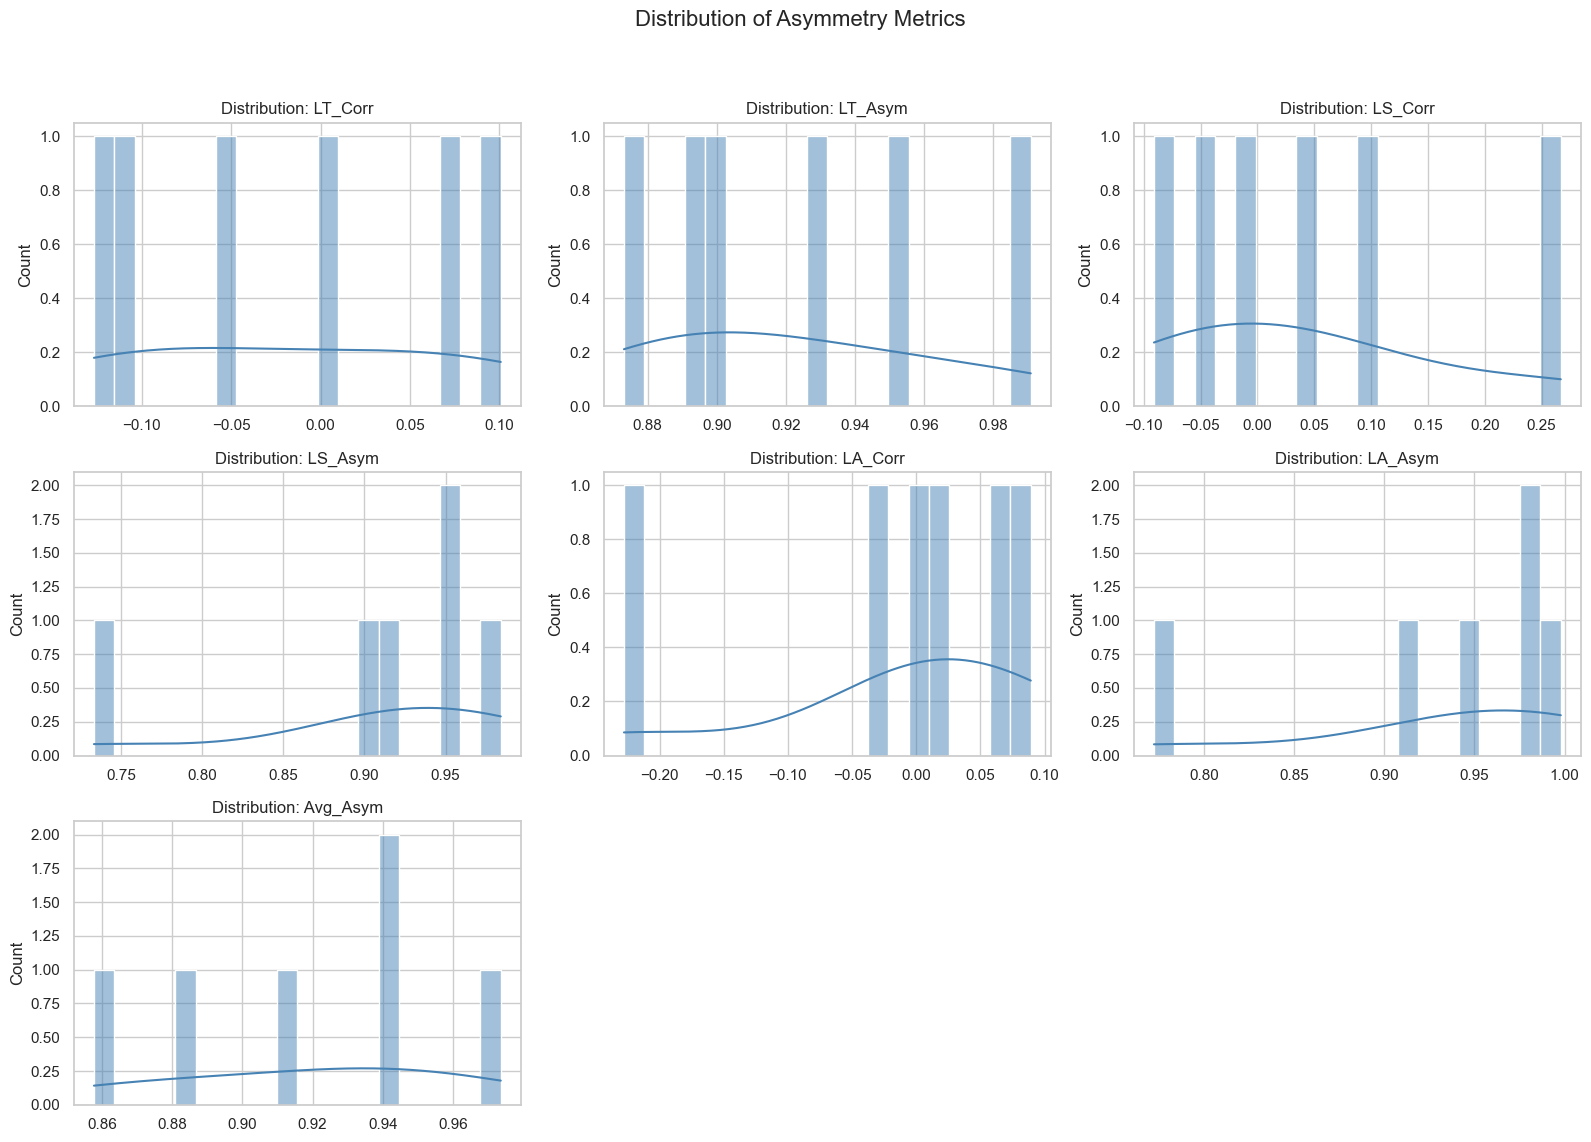

In [20]:
plot_asymmetry_summary(asymmetry_df, save=False)


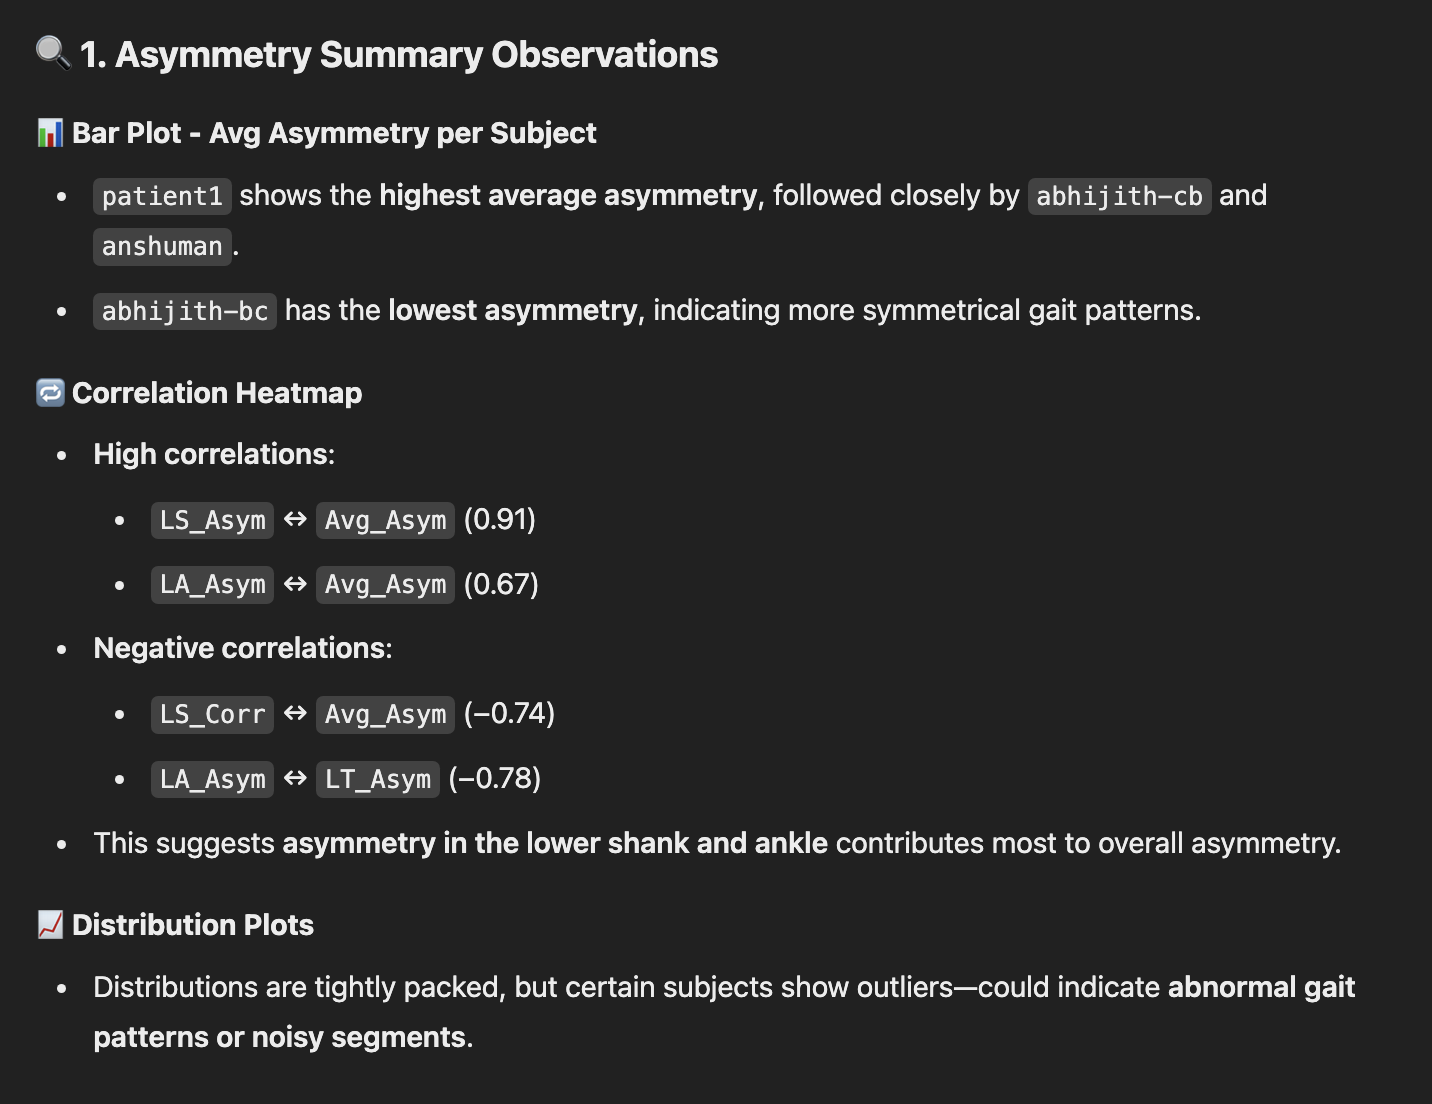

correlation differ across genders

In [21]:
# # 1. Split the dataset by Gender
# male_data = full_dataset[full_dataset["Gender"] == "Male"]
# female_data = full_dataset[full_dataset["Gender"] == "Female"]

In [22]:
# # 2. Compute correlation matrices for each gender
# male_corr = male_data[columns_of_interest].corr()
# female_corr = female_data[columns_of_interest].corr()

In [23]:
# # 3. Plot Correlation Heatmaps for Male and Female
# fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# sns.heatmap(male_corr, ax=axes[0], annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
# axes[0].set_title("Correlation Heatmap: Male")

# sns.heatmap(female_corr, ax=axes[1], annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
# axes[1].set_title("Correlation Heatmap: Female")

# plt.show()


In [24]:

# # 4. Optional: Calculate the Difference in Correlations between Genders
# corr_diff = male_corr - female_corr

In [25]:
# # 5. Plot the Correlation Difference
# plt.figure(figsize=(14, 10))
# sns.heatmap(corr_diff, annot=True, cmap="coolwarm", fmt=".2f", center=0, cbar=True)
# plt.title('Difference in Correlations: Male vs Female')
# plt.show()


time-based subject trends

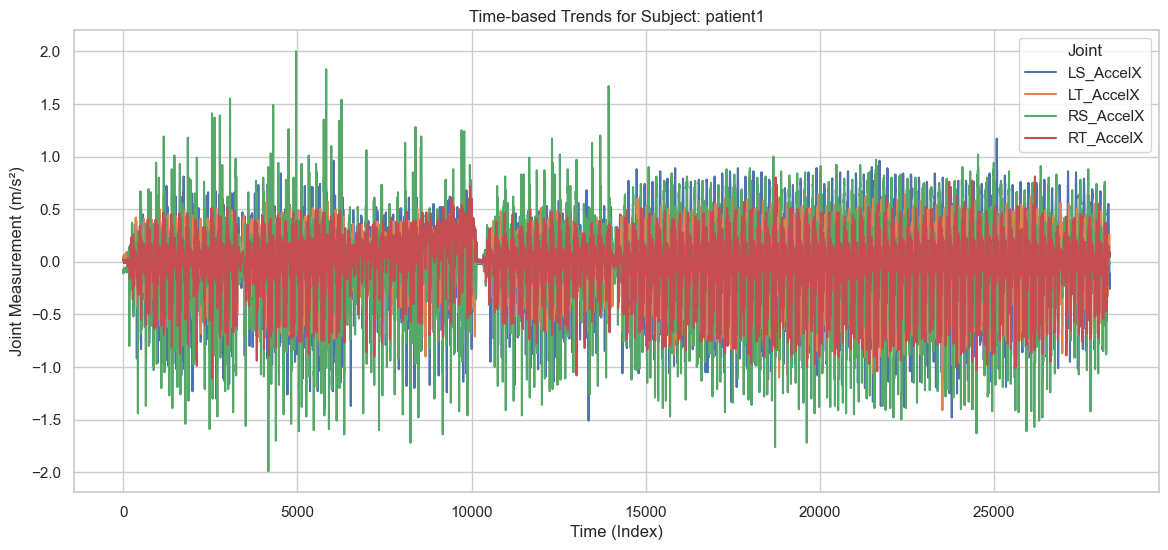

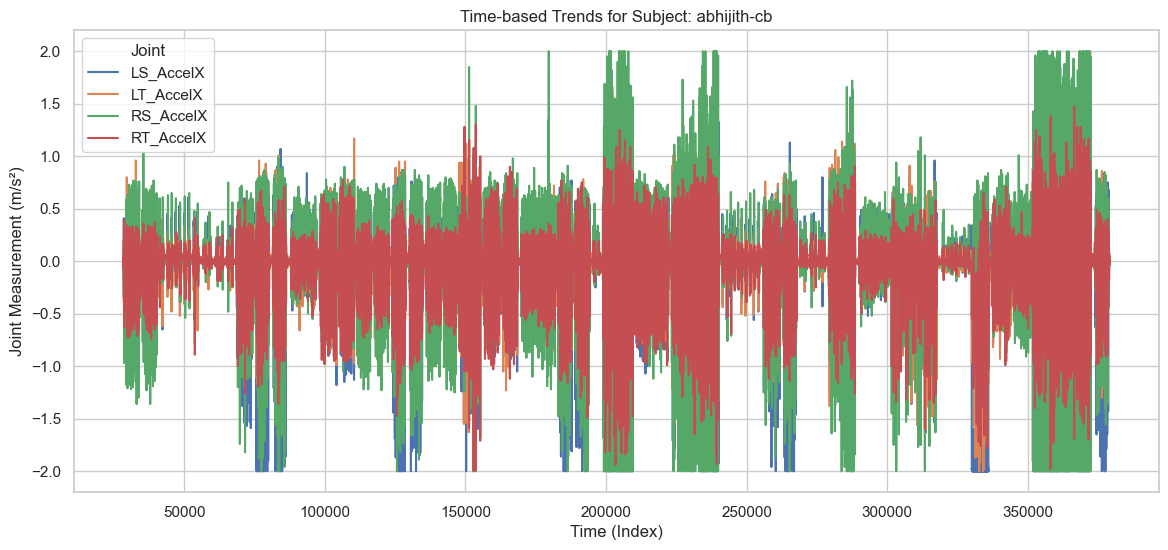

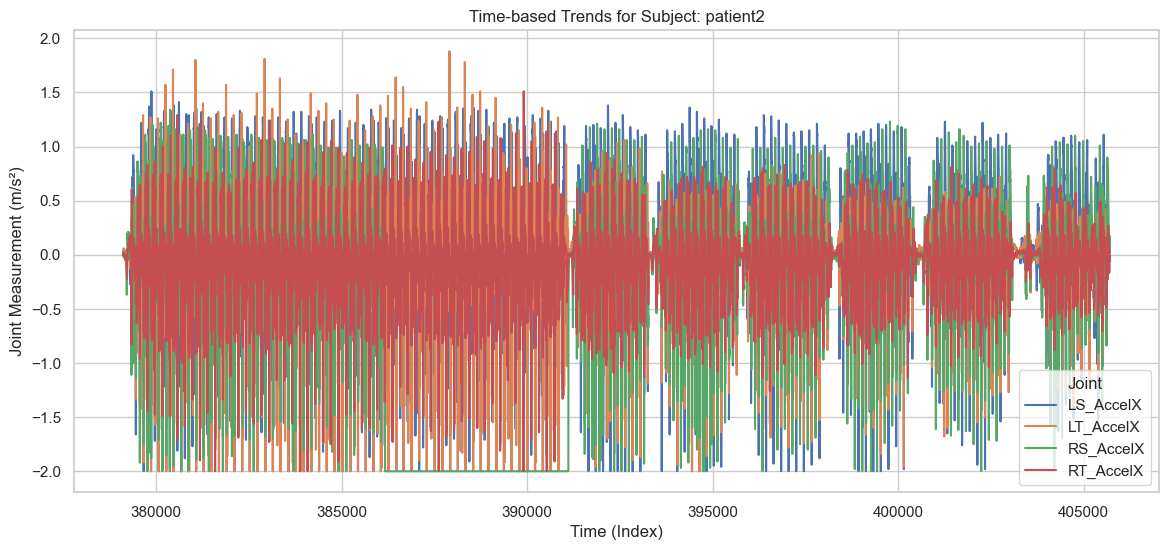

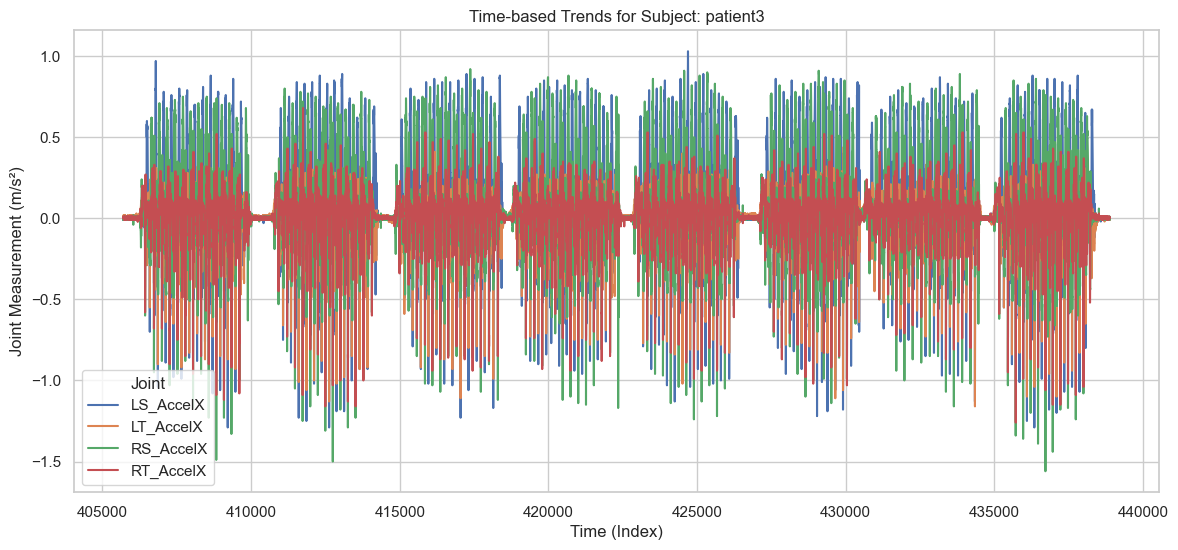

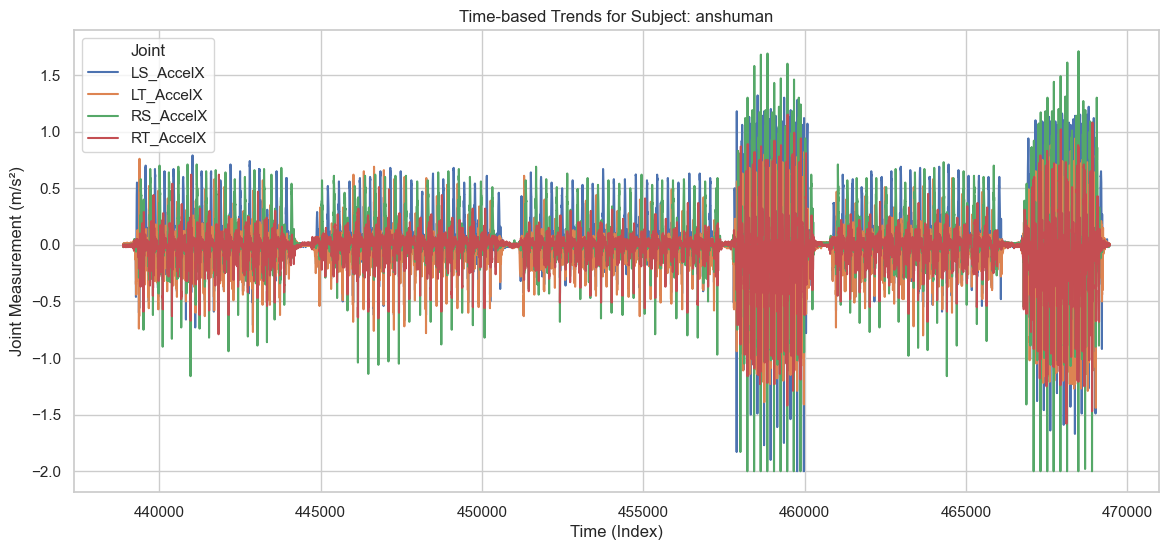

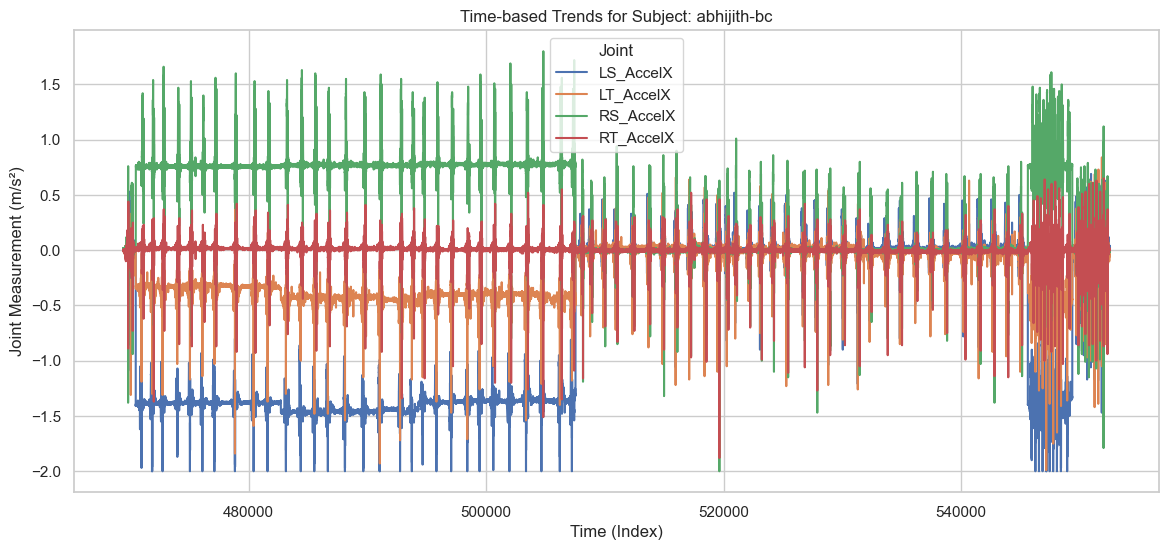

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of joints to visualize (you can expand this list if needed)
joints_of_interest = ['LS_AccelX', 'LT_AccelX', 'RS_AccelX', 'RT_AccelX']

# 1. Plotting time-series trends for each subject and joint
for subject in full_dataset['Subject'].unique():
    subject_data = full_dataset[full_dataset['Subject'] == subject]

    plt.figure(figsize=(14, 6))
    for joint in joints_of_interest:
        sns.lineplot(data=subject_data, x=subject_data.index, y=joint, label=joint)
    
    plt.title(f'Time-based Trends for Subject: {subject}')
    plt.xlabel('Time (Index)')
    plt.ylabel('Joint Measurement (m/s²)')
    plt.legend(title="Joint")
    plt.show()


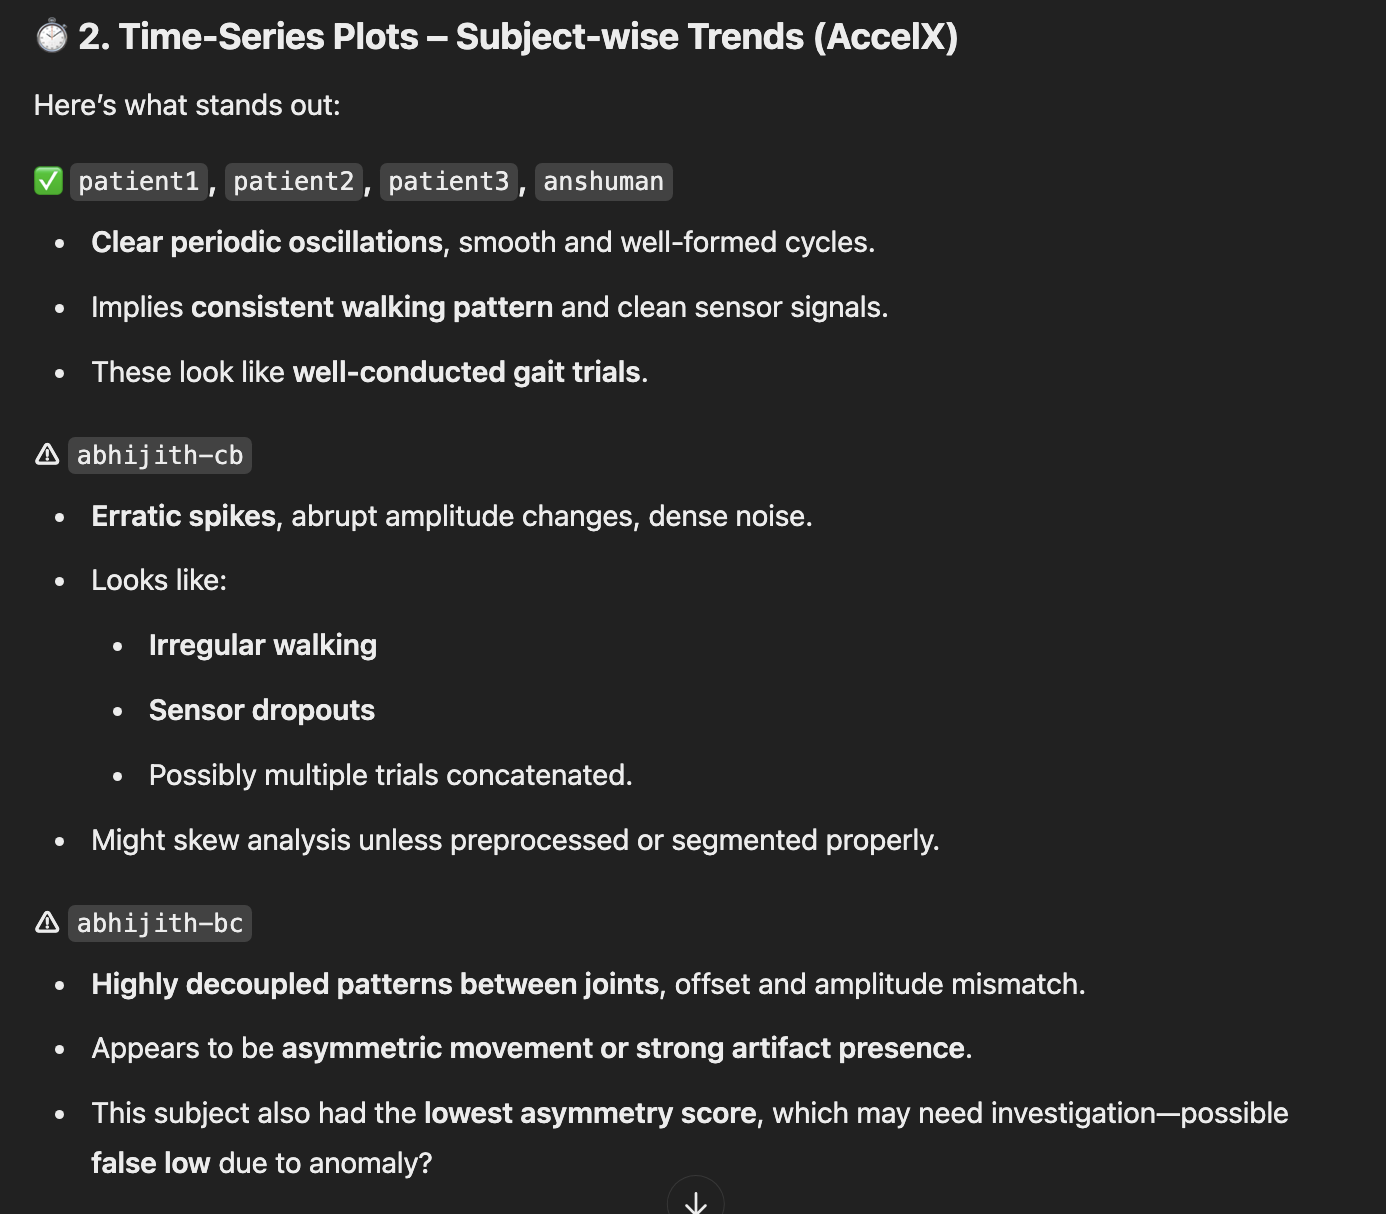

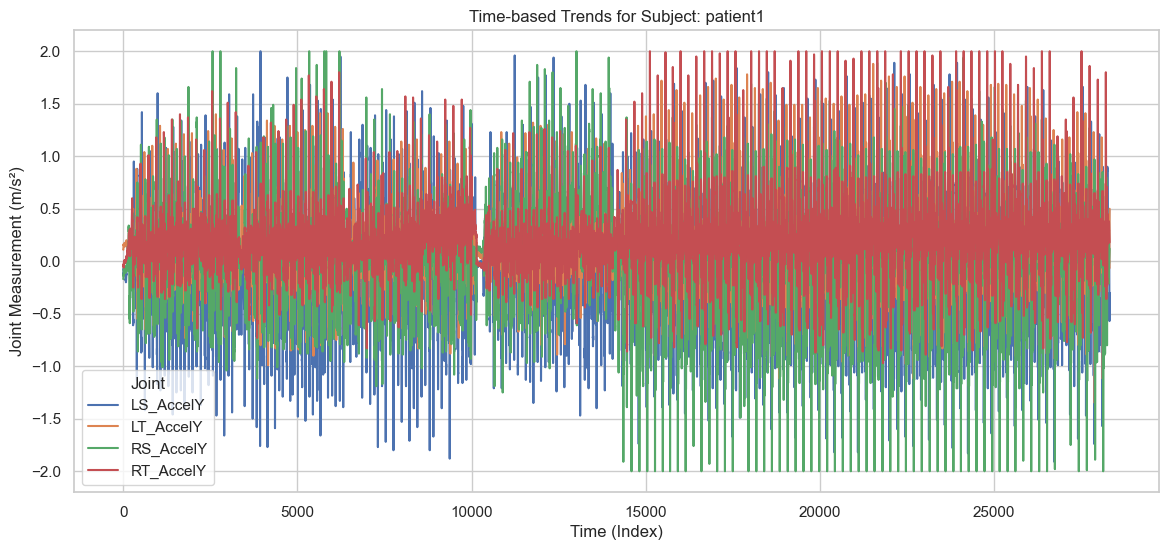

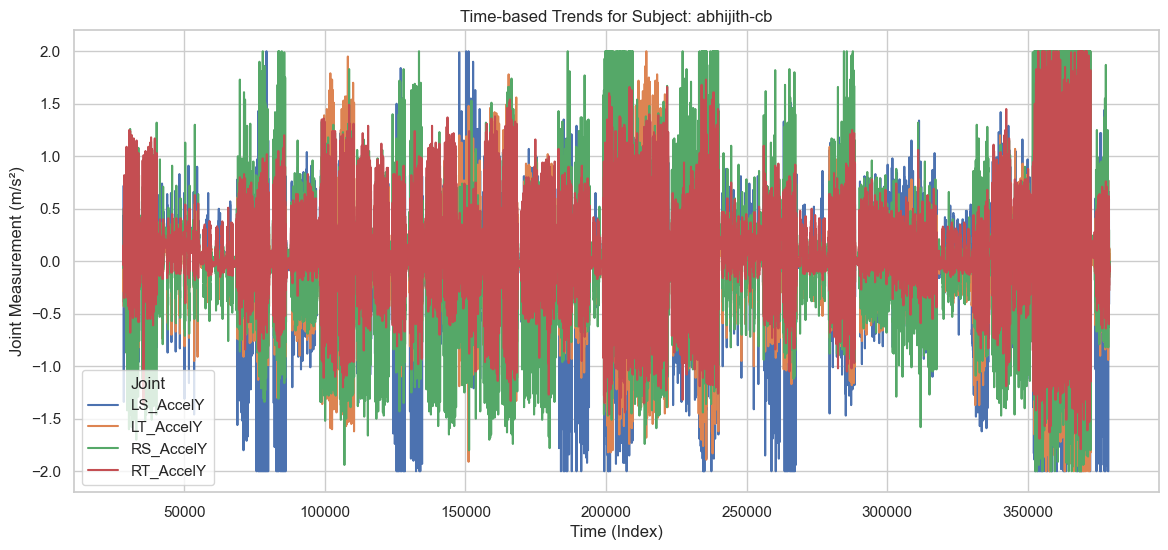

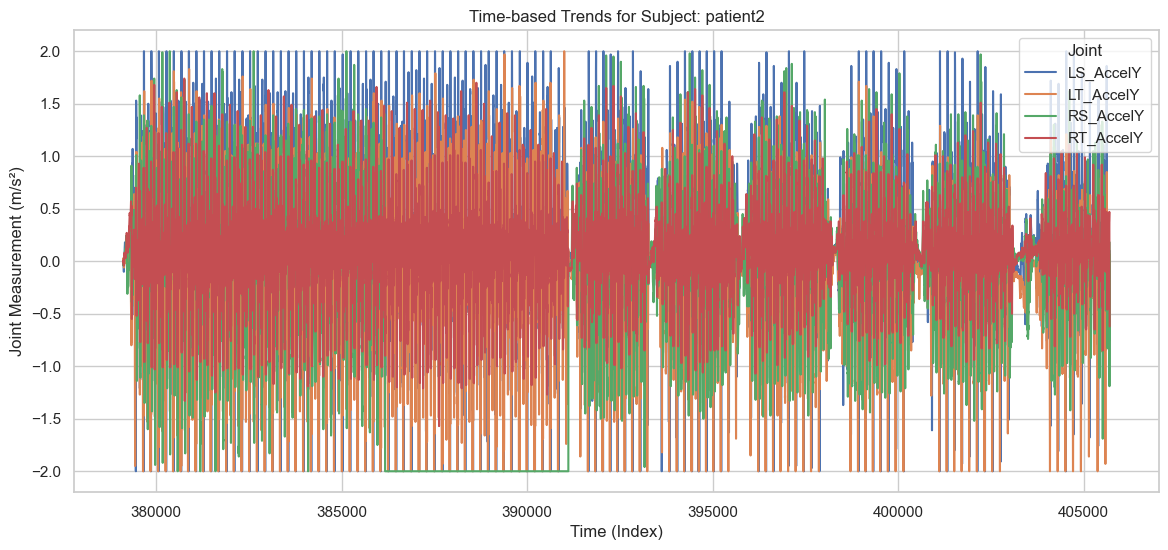

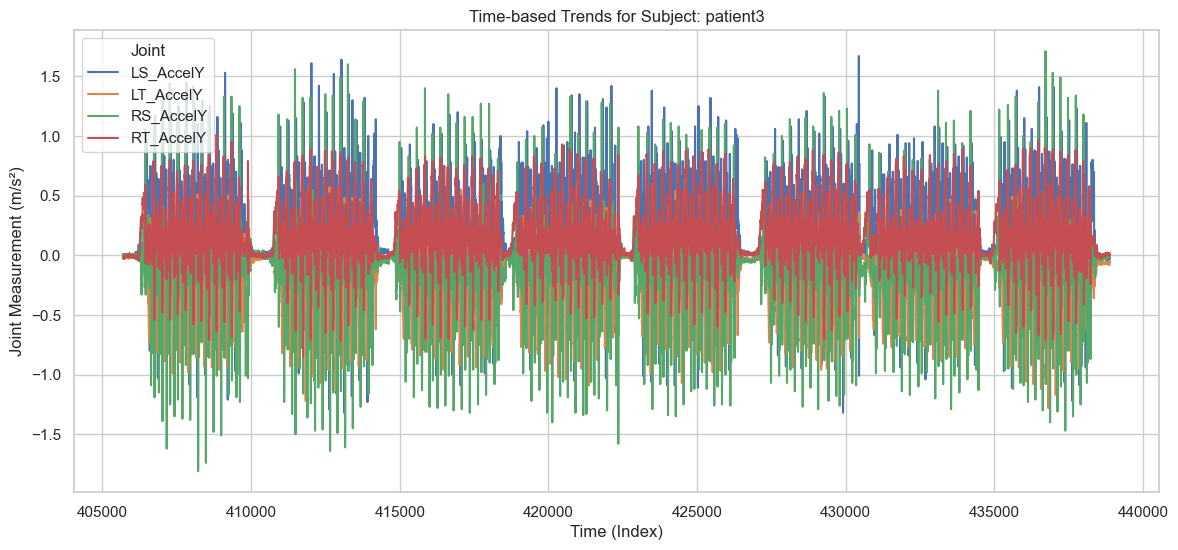

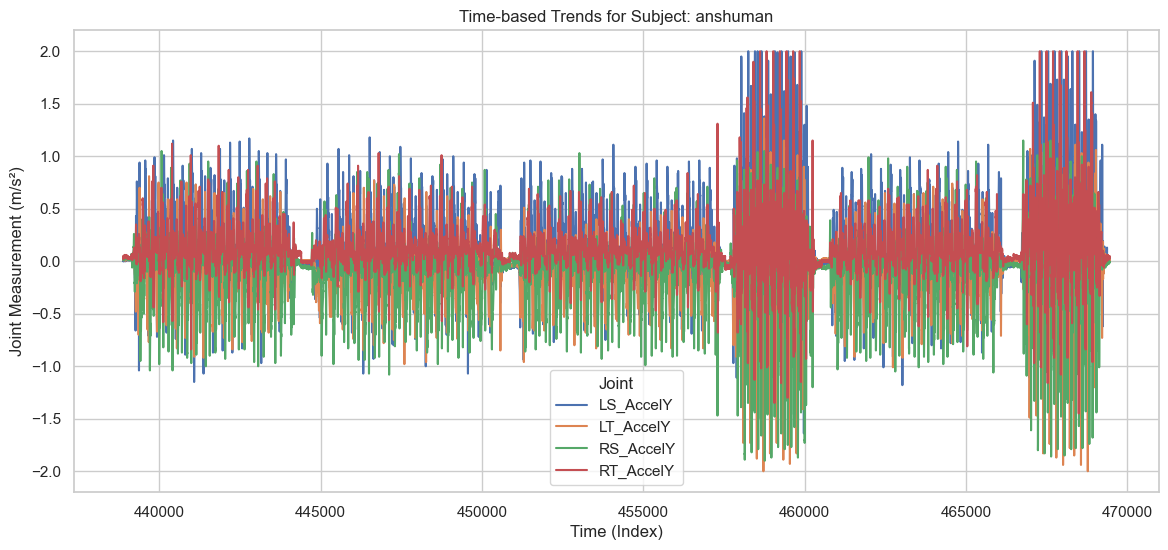

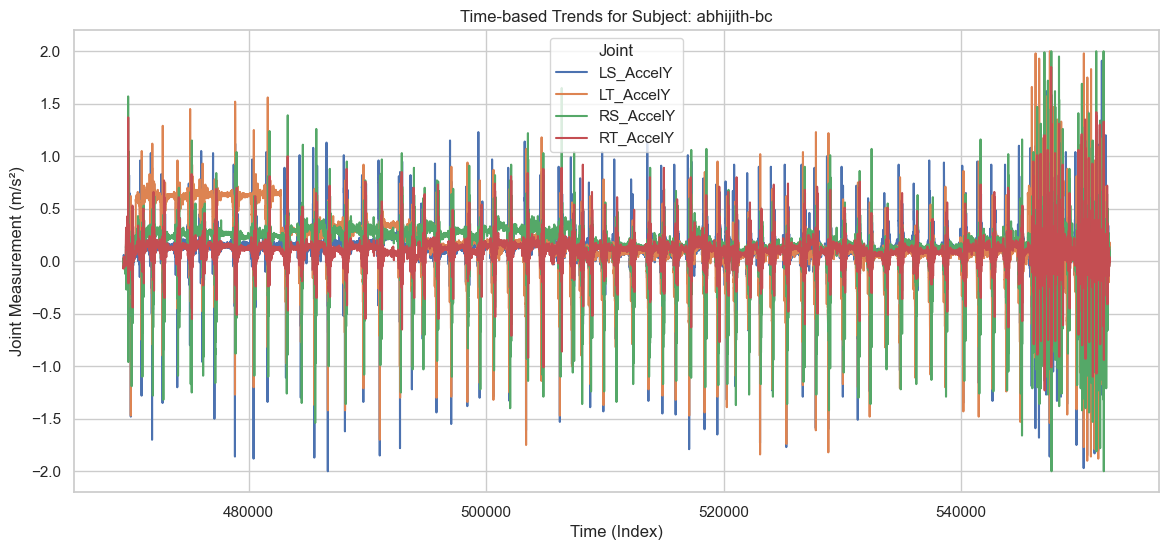

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of joints to visualize (you can expand this list if needed)
joints_of_interest = ['LS_AccelY', 'LT_AccelY', 'RS_AccelY', 'RT_AccelY']

# 1. Plotting time-series trends for each subject and joint
for subject in full_dataset['Subject'].unique():
    subject_data = full_dataset[full_dataset['Subject'] == subject]

    plt.figure(figsize=(14, 6))
    for joint in joints_of_interest:
        sns.lineplot(data=subject_data, x=subject_data.index, y=joint, label=joint)
    
    plt.title(f'Time-based Trends for Subject: {subject}')
    plt.xlabel('Time (Index)')
    plt.ylabel('Joint Measurement (m/s²)')
    plt.legend(title="Joint")
    plt.show()


In [27]:
# Reshape data for analysis — exclude both 'Subject' and 'Trial'


# Remove non-numeric values if they somehow slipped in
reshaped_data = reshaped_data[pd.to_numeric(reshaped_data['Value'], errors='coerce').notna()]
reshaped_data['Value'] = reshaped_data['Value'].astype(float)

# Extract sensor info
reshaped_data['BodyPart'] = reshaped_data['Measurement'].str.extract(r'^[LR](T|S|A)').replace({'T': 'Thigh', 'S': 'Shank', 'A': 'Ankle'})
reshaped_data['SensorType'] = reshaped_data['Measurement'].apply(lambda x: 'Accel' if 'Accel' in x else 'Gyro')
reshaped_data['Axis'] = reshaped_data['Measurement'].str.extract(r'(X|Y|Z)$')
reshaped_data['Joint'] = reshaped_data['SensorType'] + "_" + reshaped_data['BodyPart'] + "_" + reshaped_data['Axis']

In [28]:
print(reshaped_data.columns)
print(reshaped_data['BodyPart'].unique())
print(reshaped_data['SensorType'].unique())
print(reshaped_data['Axis'].unique())
print(reshaped_data['Joint'].unique())

Index(['Subject', 'Trial', 'Measurement', 'Value', 'Joint', 'Side', 'BodyPart',
       'SensorType', 'Axis'],
      dtype='object')
['Shank' 'Ankle' 'Thigh']
['Accel' 'Gyro']
['X' 'Y' 'Z']
['Accel_Shank_X' 'Accel_Shank_Y' 'Accel_Shank_Z' 'Gyro_Shank_X'
 'Gyro_Shank_Y' 'Gyro_Shank_Z' 'Accel_Ankle_X' 'Accel_Ankle_Y'
 'Accel_Ankle_Z' 'Gyro_Ankle_X' 'Gyro_Ankle_Y' 'Gyro_Ankle_Z'
 'Accel_Thigh_X' 'Accel_Thigh_Y' 'Accel_Thigh_Z' 'Gyro_Thigh_X'
 'Gyro_Thigh_Y' 'Gyro_Thigh_Z']


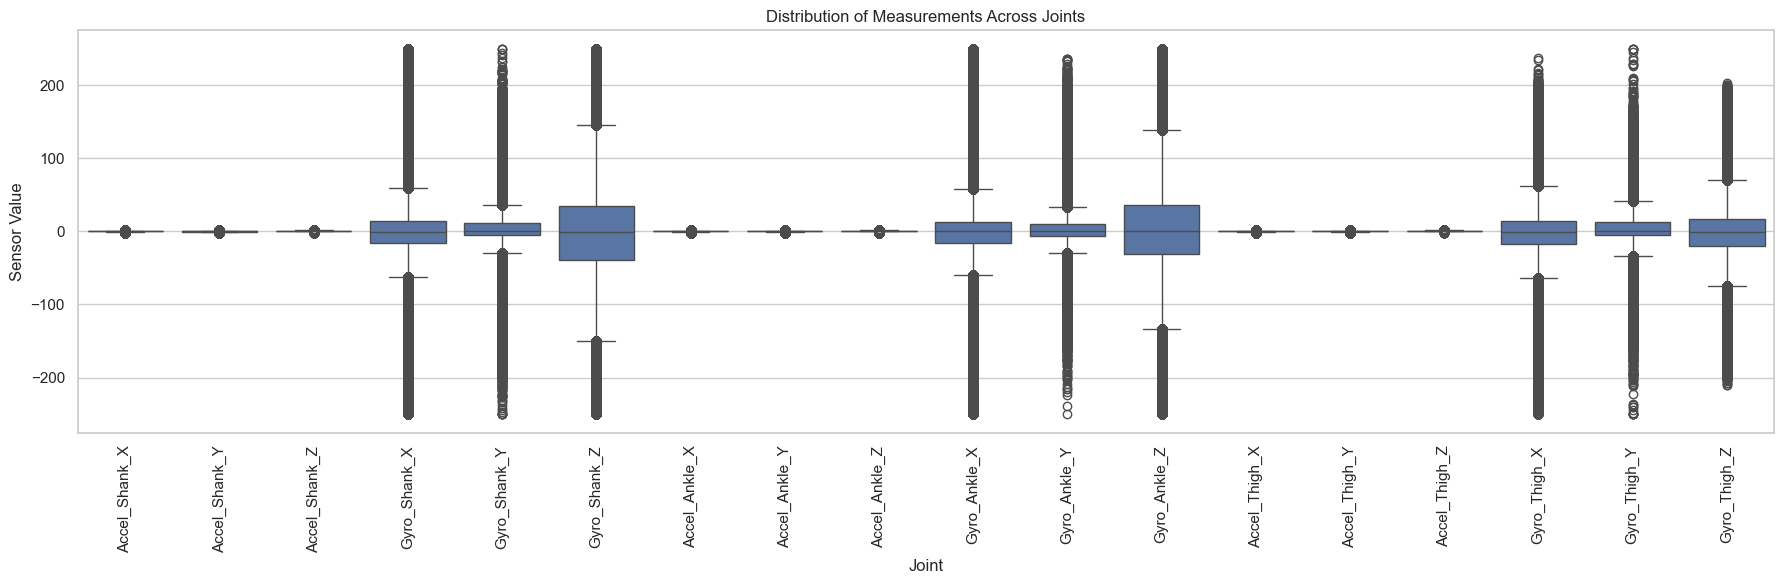

In [29]:
# Plot the boxplot
plt.figure(figsize=(18, 6))
sns.boxplot(data=reshaped_data, x='Joint', y='Value')
plt.xticks(rotation=90)
plt.title('Distribution of Measurements Across Joints')
plt.xlabel('Joint')
plt.ylabel('Sensor Value')
plt.tight_layout()
plt.show()


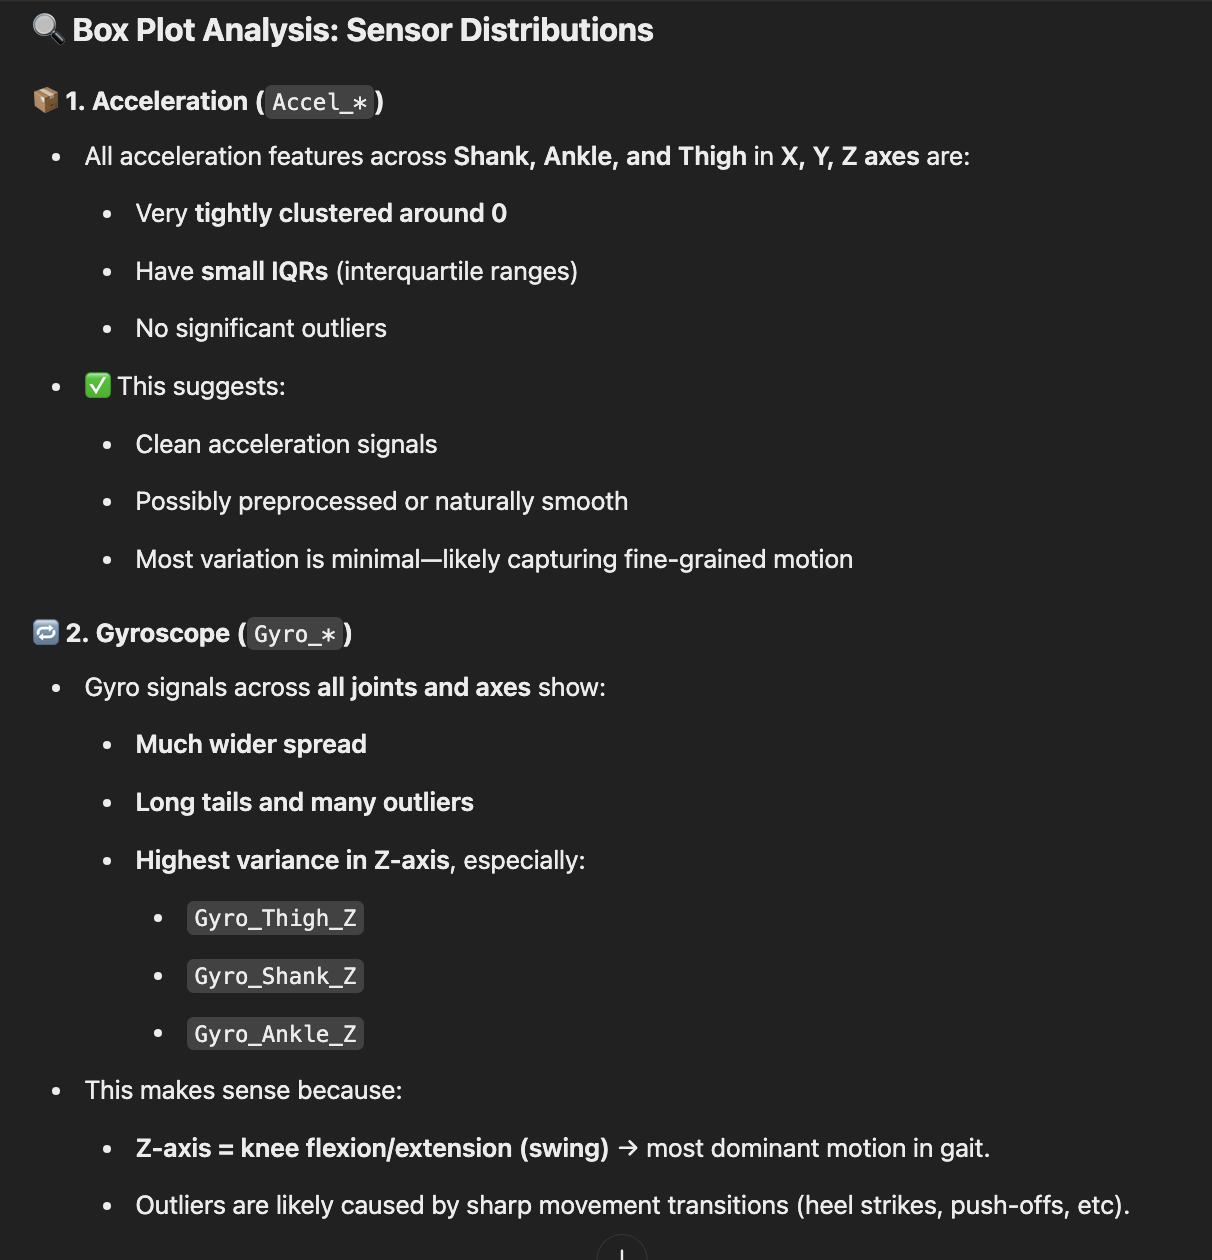

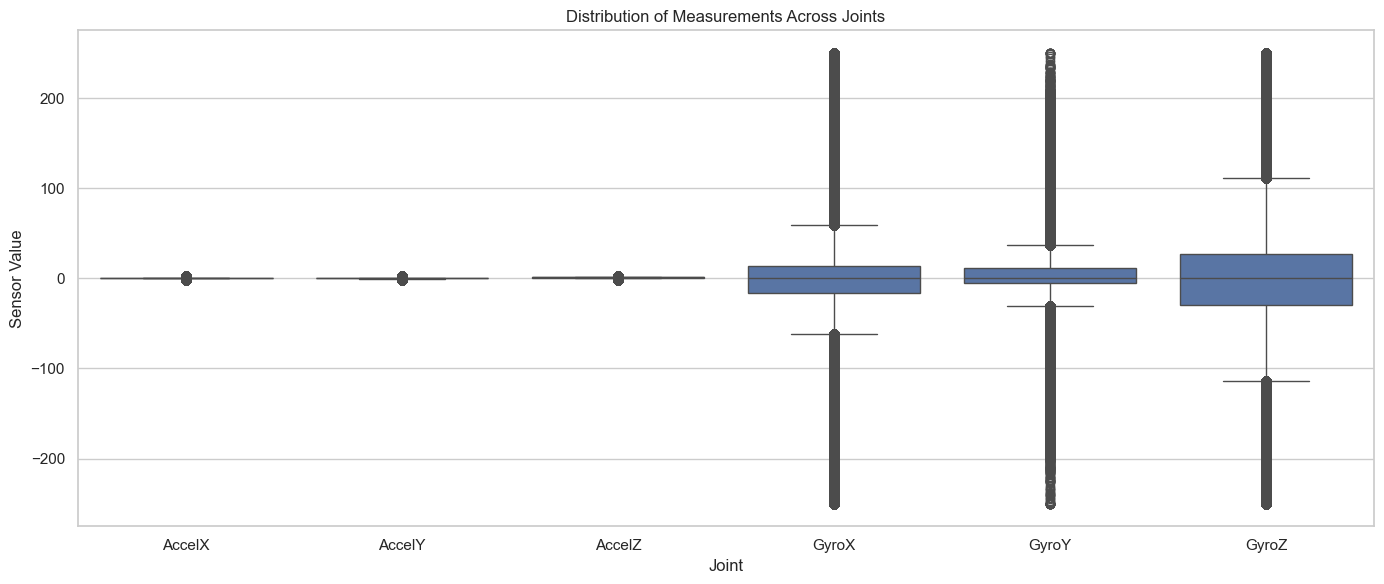

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Clean: Ensure all values are numeric
reshaped_data = reshaped_data[pd.to_numeric(reshaped_data['Value'], errors='coerce').notna()]
reshaped_data['Value'] = reshaped_data['Value'].astype(float)

# Extract the final part (e.g. AccelX, GyroZ) as the joint
reshaped_data['Joint'] = reshaped_data['Measurement'].str.extract(r'_(Accel[XYZ]|Gyro[XYZ])$')

# Plot: Distribution of Measurements Across Joints (AccelX, GyroY, etc.)
plt.figure(figsize=(14, 6))
sns.boxplot(data=reshaped_data, x='Joint', y='Value')
plt.title('Distribution of Measurements Across Joints')
plt.xlabel('Joint')
plt.ylabel('Sensor Value')
plt.tight_layout()
plt.show()


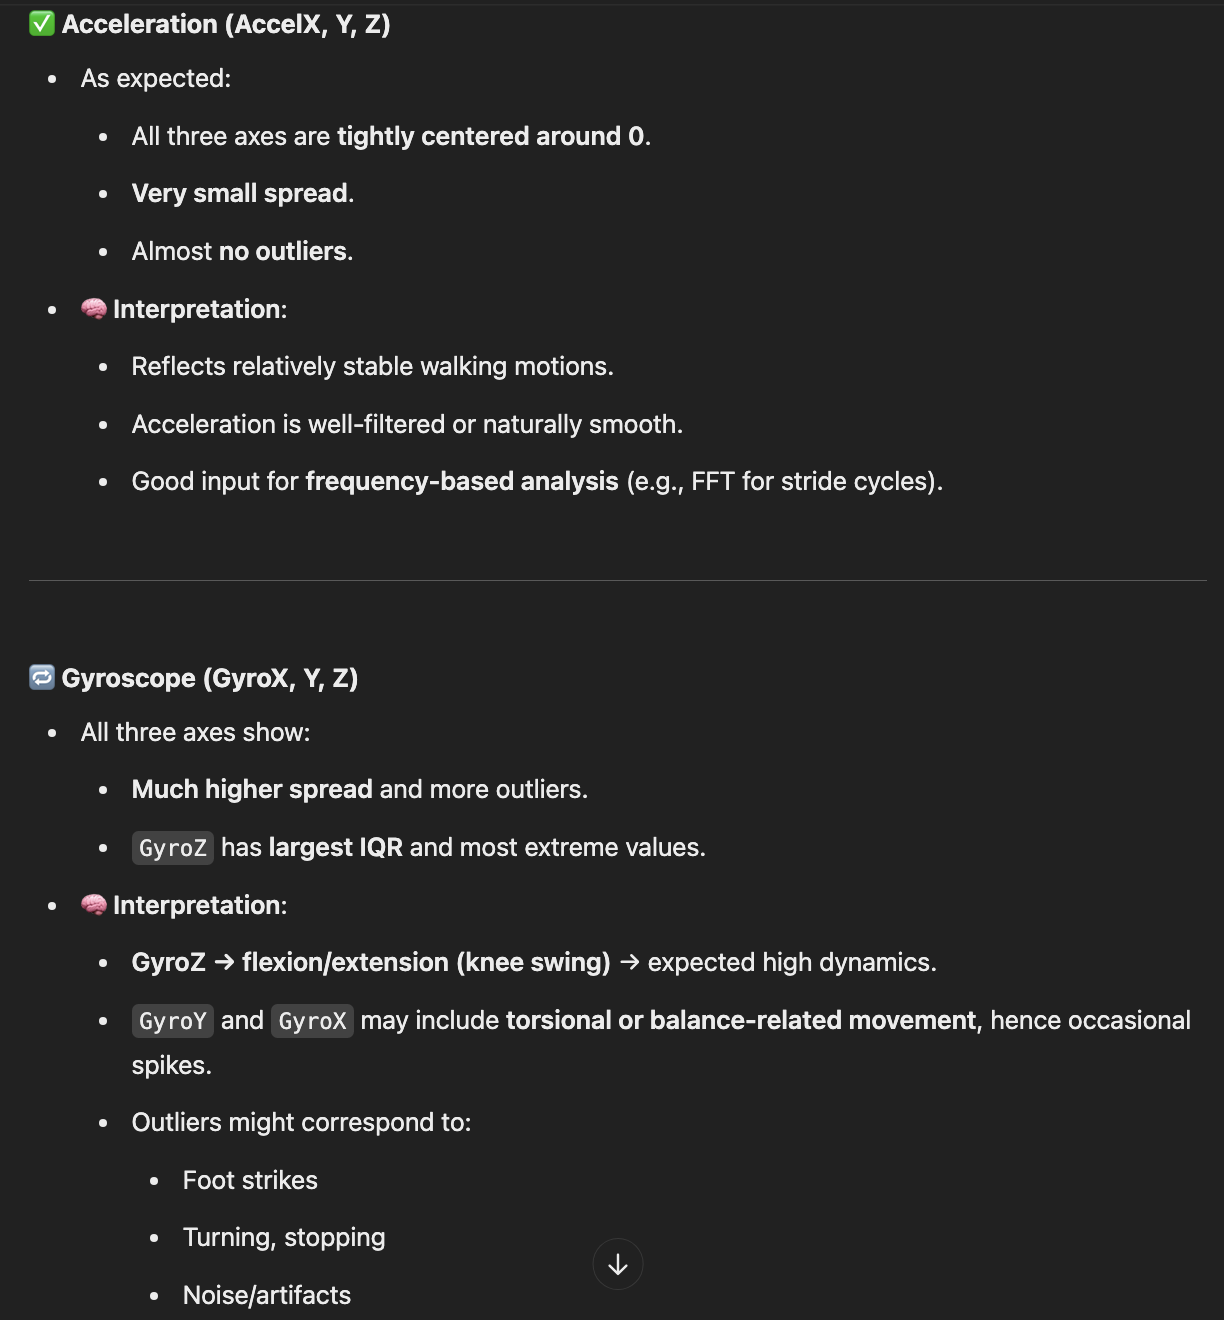

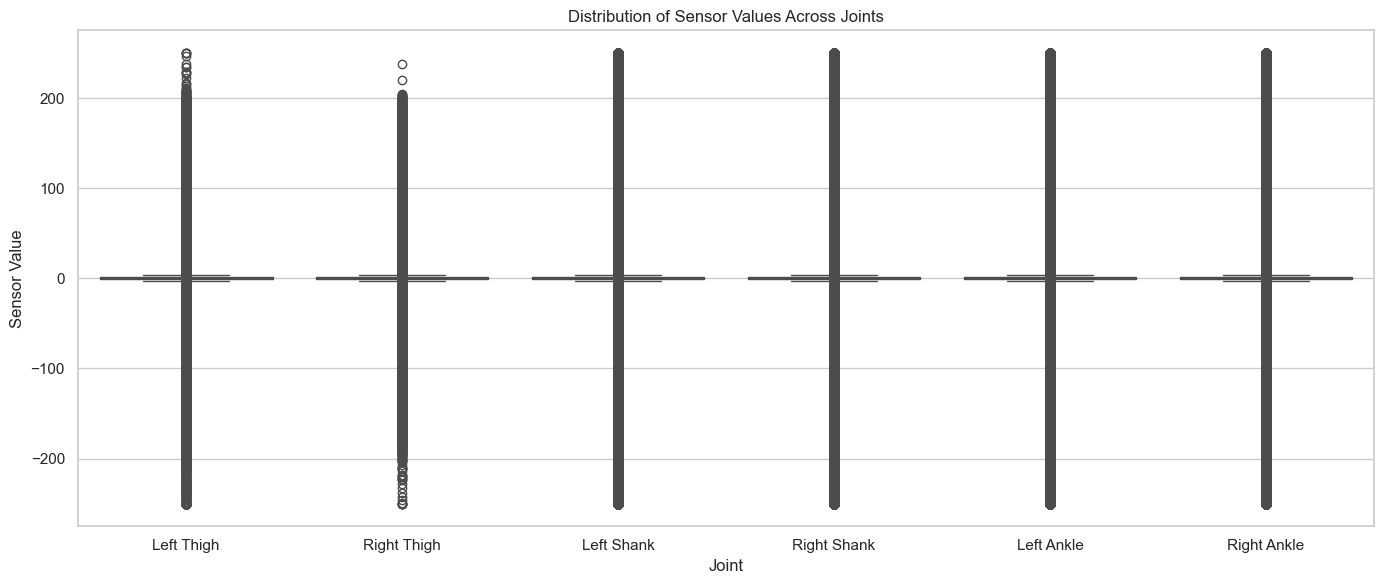

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure numeric values
reshaped_data = reshaped_data[pd.to_numeric(reshaped_data['Value'], errors='coerce').notna()]
reshaped_data['Value'] = reshaped_data['Value'].astype(float)

# Map sensor ID prefixes to anatomical joint labels
joint_map = {
    'LT': 'Left Thigh',
    'RT': 'Right Thigh',
    'LS': 'Left Shank',
    'RS': 'Right Shank',
    'LA': 'Left Ankle',
    'RA': 'Right Ankle'
}

# Extract prefix from measurement name (e.g., LT, RS, LA, etc.)
reshaped_data['Prefix'] = reshaped_data['Measurement'].str.extract(r'^(LT|RT|LS|RS|LA|RA)')
reshaped_data['Joint'] = reshaped_data['Prefix'].map(joint_map)

# Plot: Sensor Value Distribution by Joint
plt.figure(figsize=(14, 6))
sns.boxplot(data=reshaped_data, x='Joint', y='Value',
            order=['Left Thigh', 'Right Thigh', 'Left Shank', 'Right Shank', 'Left Ankle', 'Right Ankle'])
plt.title('Distribution of Sensor Values Across Joints')
plt.xlabel('Joint')
plt.ylabel('Sensor Value')
plt.tight_layout()
plt.show()


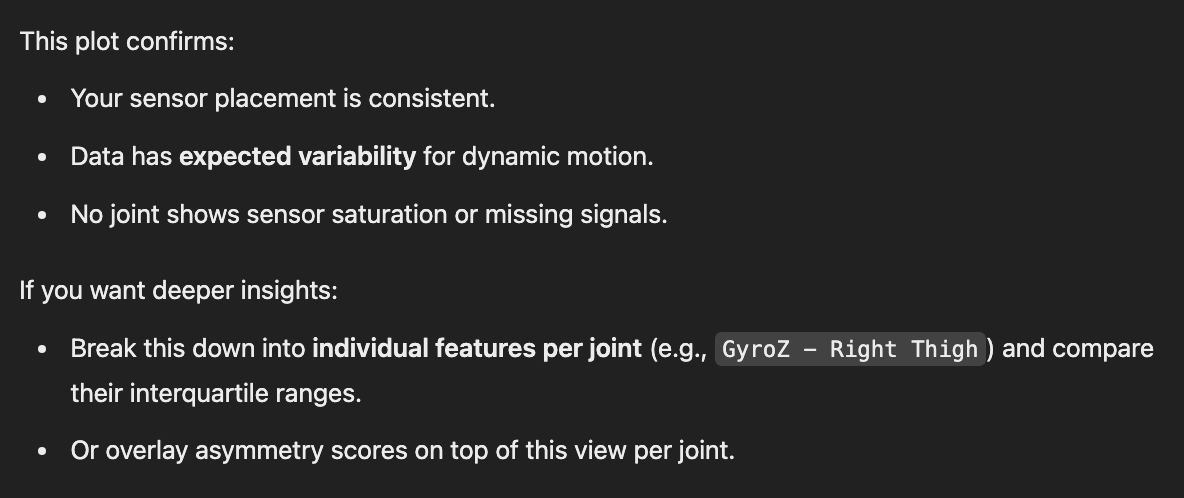

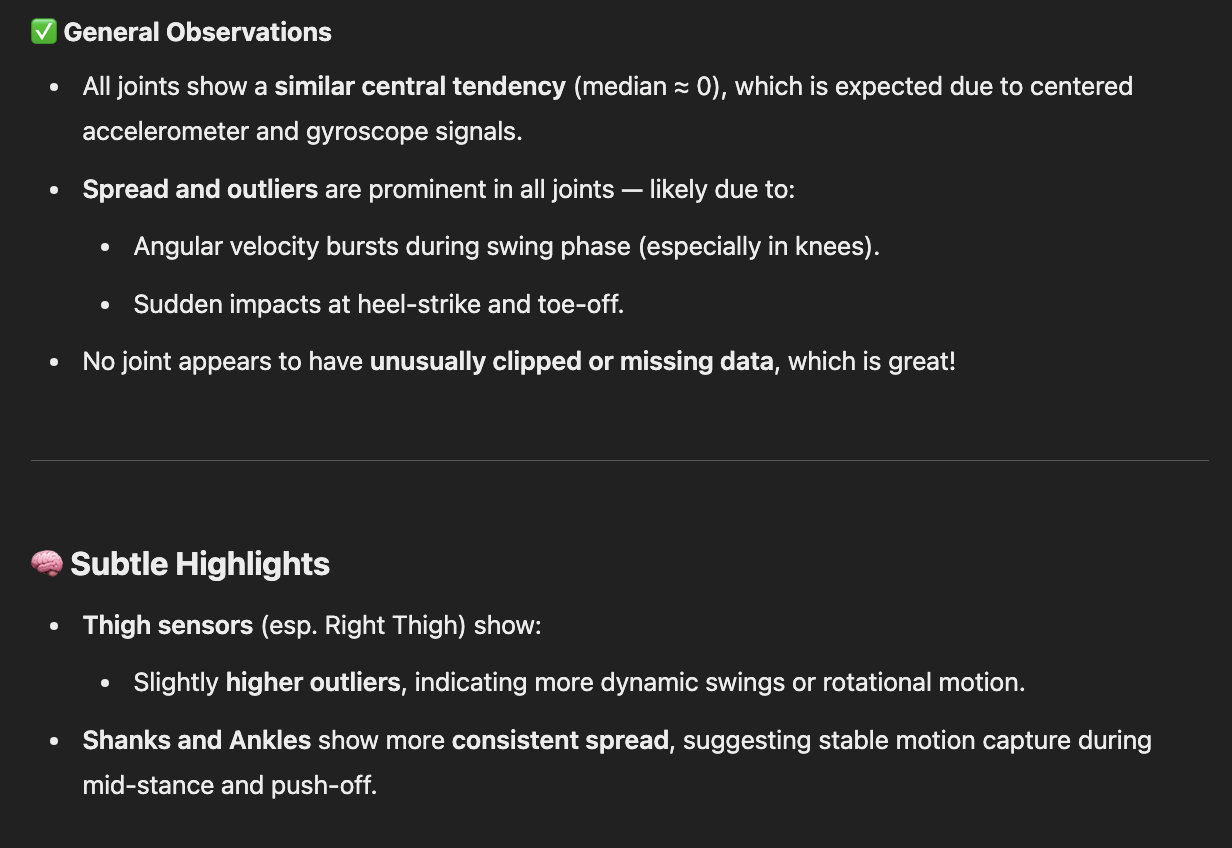

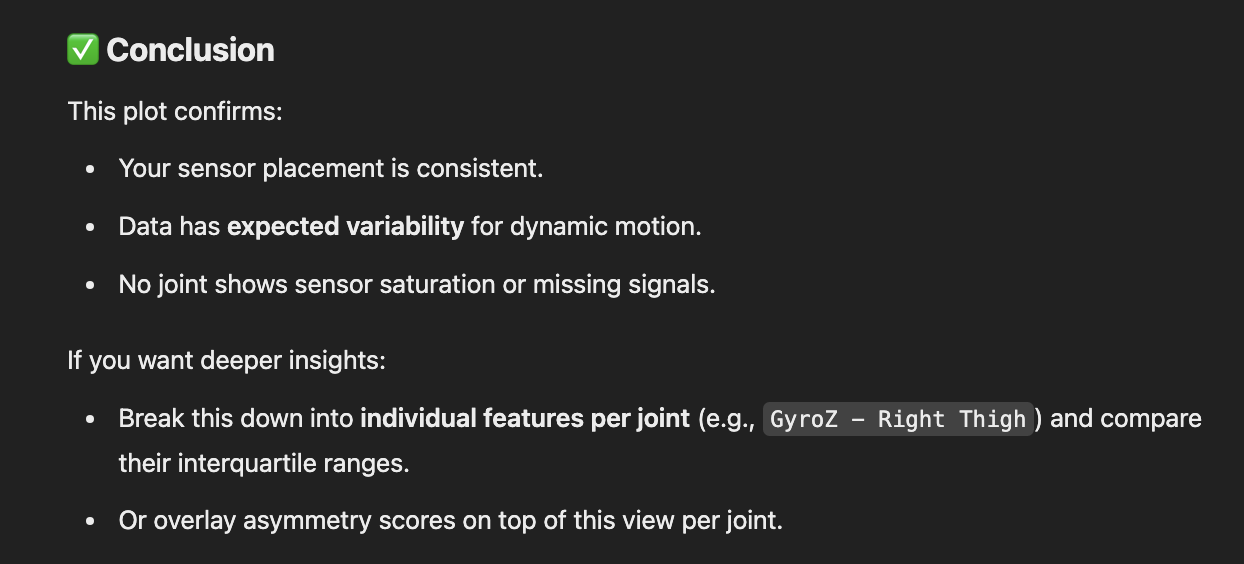

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


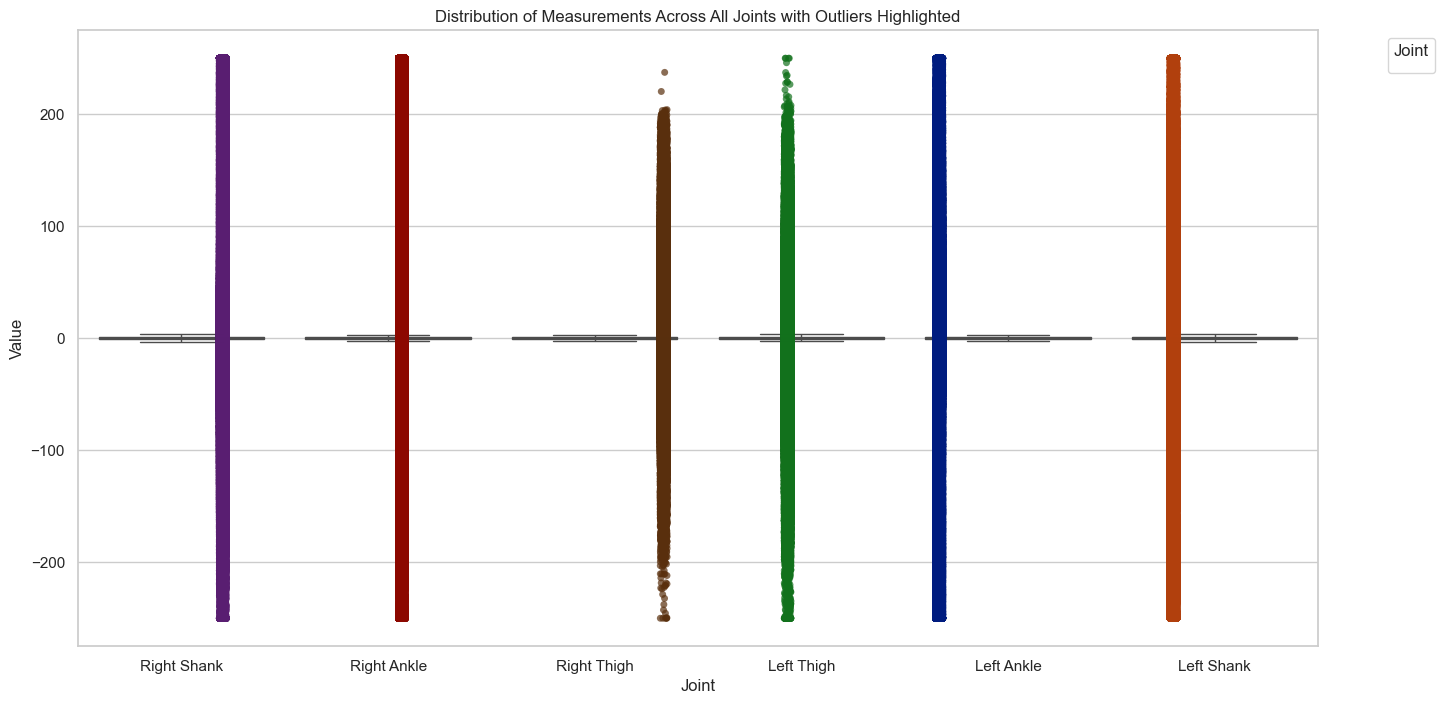

In [32]:
# 3. Identify Outliers: Values Outside 1.5 * IQR for Each Joint
def mark_outliers(group):
    """Adds an 'Outlier' column to mark outliers within each group."""
    Q1 = group['Value'].quantile(0.25)
    Q3 = group['Value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    group['Outlier'] = (group['Value'] < lower_bound) | (group['Value'] > upper_bound)
    return group

outliers = reshaped_data.groupby('Joint').apply(mark_outliers).reset_index(drop=True)


# 4. Plot: Box Plot with Outliers Highlighted for All Joints
plt.figure(figsize=(16, 8))

# Plot regular boxplot without showing default outliers
sns.boxplot(data=reshaped_data, x='Joint', y='Value', showfliers=False)

# Overlay outliers using a strip plot
sns.stripplot(data=outliers, x='Joint', y='Value', 
              hue='Joint', palette='dark', dodge=True, 
              marker='o', size=5, alpha=0.7)

# Customize plot appearance
plt.title('Distribution of Measurements Across All Joints with Outliers Highlighted')
plt.xlabel('Joint')
plt.ylabel('Value')
plt.legend(title='Joint', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()


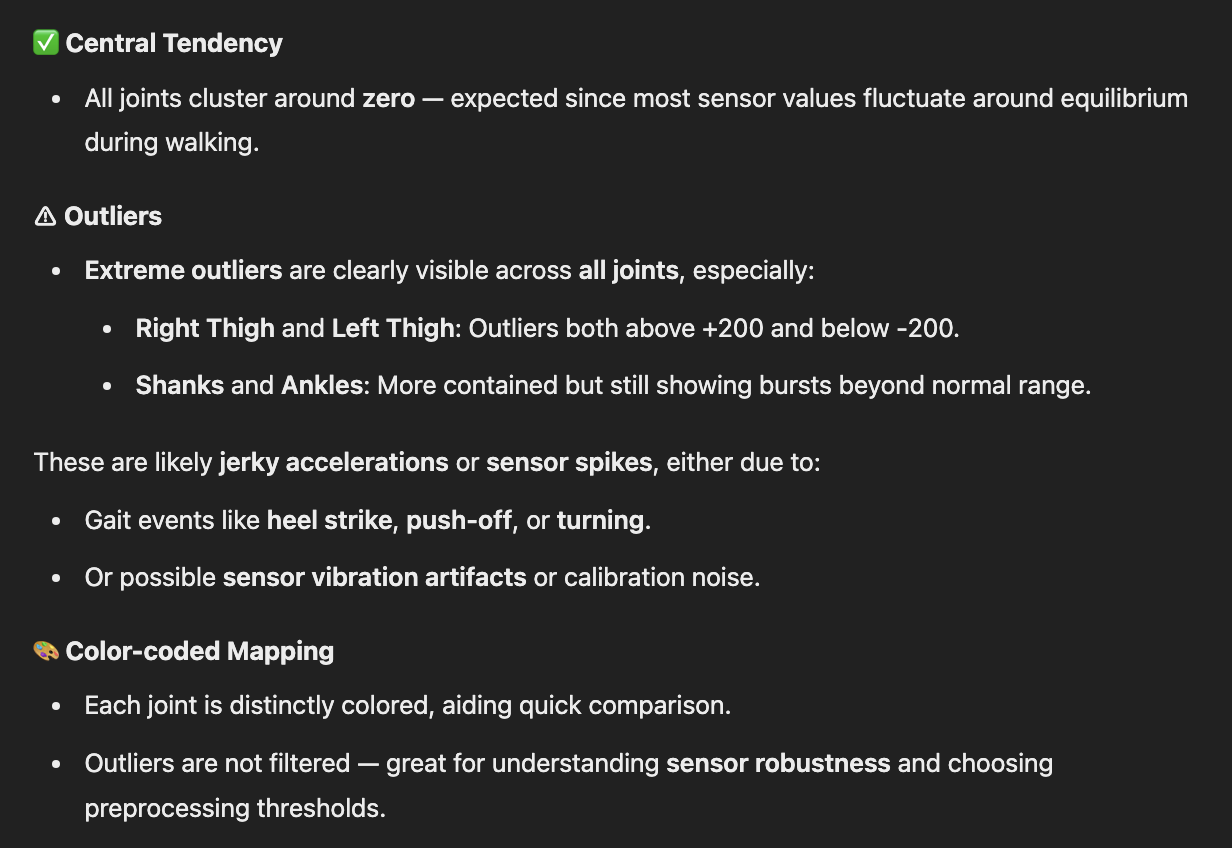